# Evaluation 2DoF Point Robot

In this notebook we will evaluate the extended A* using a point robot in a 2 DoF environment. First let us take a look at the environments used for evaluation:

----- benchmark: Big_Blocks -----


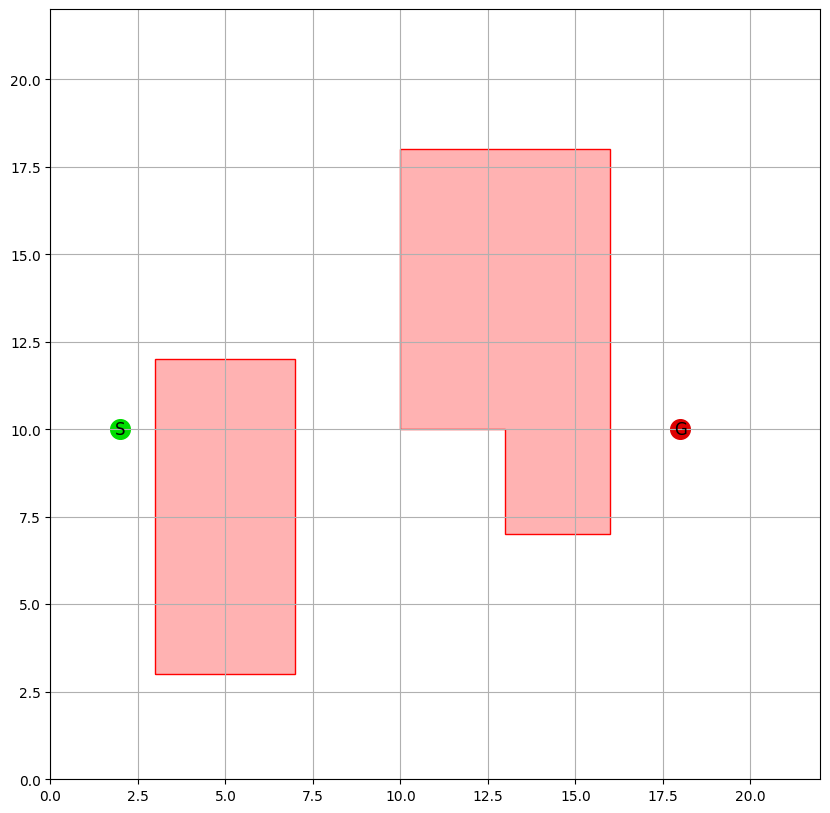

----- benchmark: Filters -----


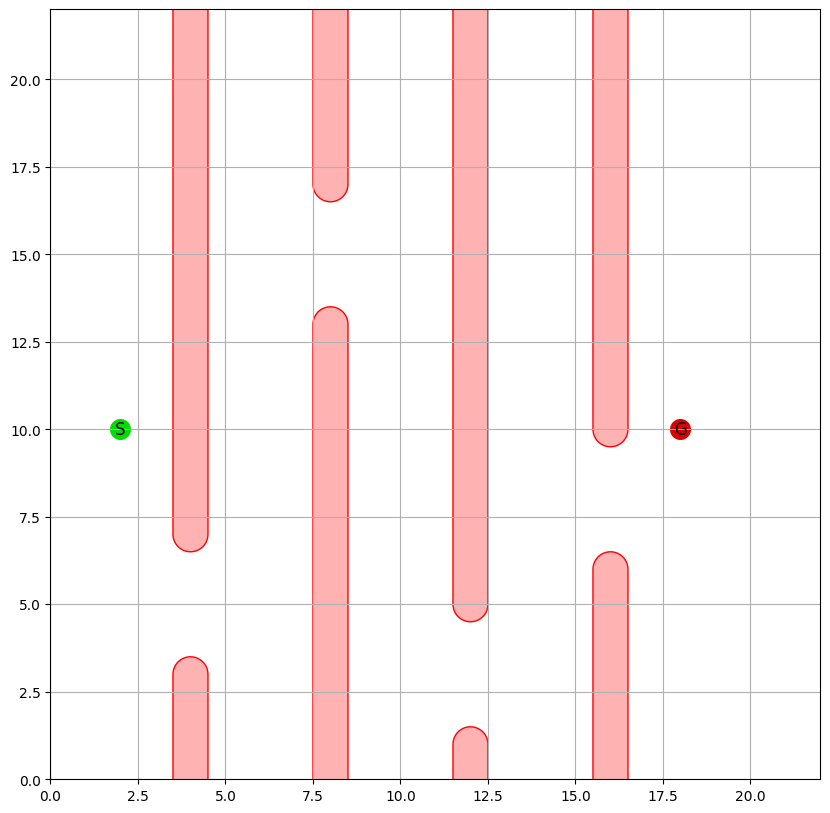

----- benchmark: Bubble_Bath -----


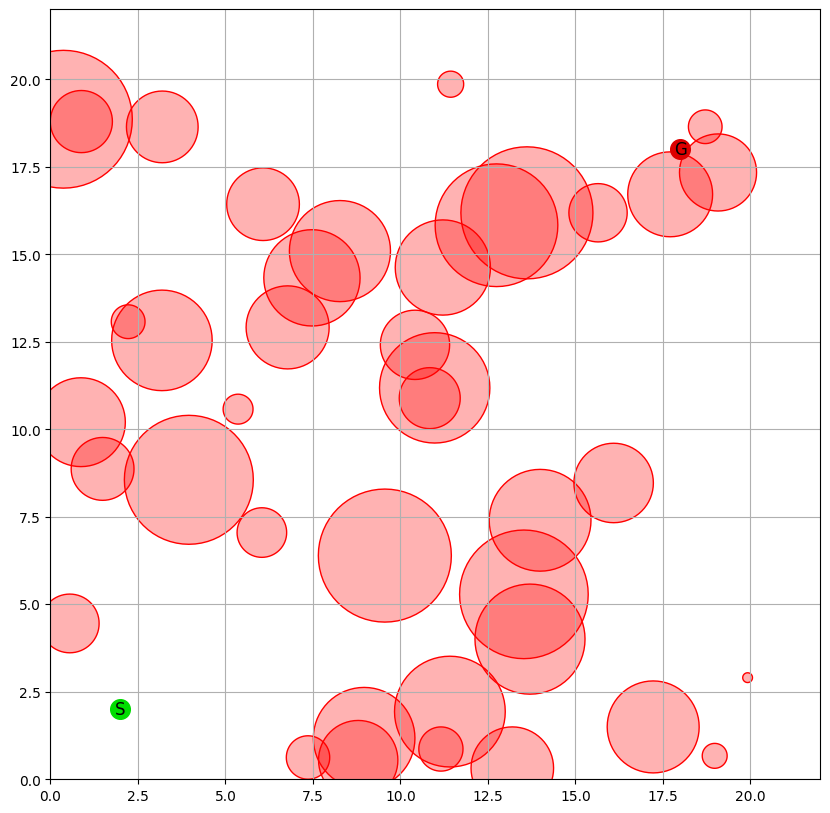

----- benchmark: Mikado -----


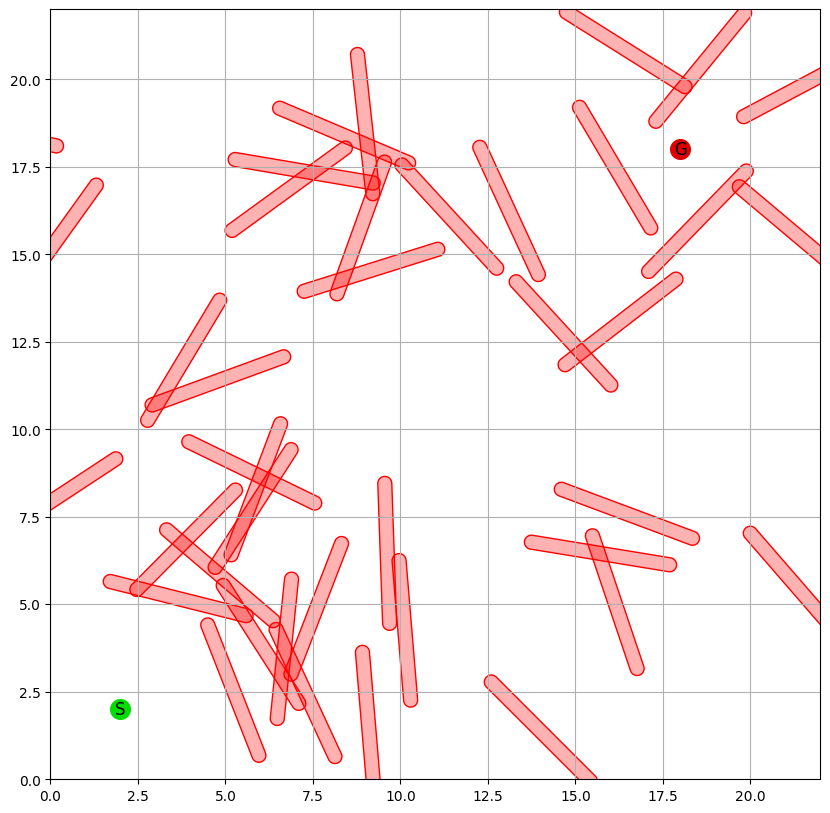

----- benchmark: Maze -----


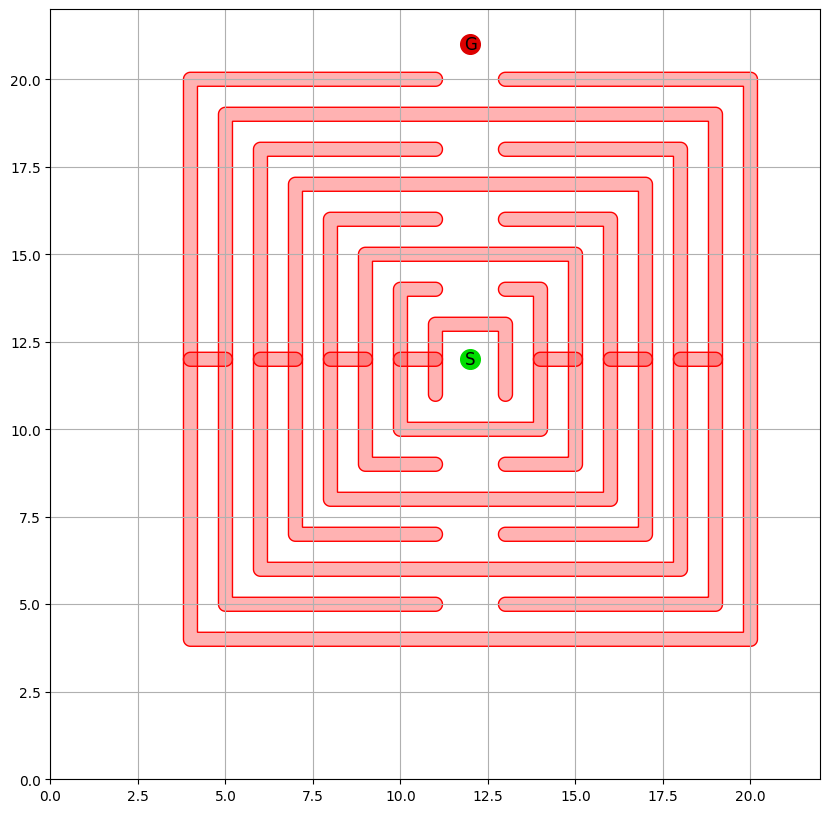

In [20]:
from core.IPBenchmark import Benchmark 
import evaluation.two_dof.IPTestSuite_2DoF as ts
import matplotlib.pyplot as plt

from evaluation.two_dof.PlotEnvironments import visualizeBenchmark

#because of time constraints we use a selection of benchmarks instead of the whole list.
evaluation_indices = [0, 1, 2, 3, 6]

for benchmark in [ts.benchList[i] for i in evaluation_indices]:
        benchmark: Benchmark
        print(f"----- benchmark: {benchmark.name} -----")
        fig, ax = visualizeBenchmark(benchmark)
        plt.show()

## Evaluation Code

In this section you can find some code for evaluating A*, loading existing results and plotting the results.

In [21]:
import os
import json
import networkx as nx
from typing import List, Dict

import sys
import os

sys.path.append(os.path.join(os.getcwd(), 'core'))
sys.path.append(os.path.join(os.getcwd(), 'evaluation/two_dof'))

from core.IPAStarExtended import AStar
from Benchmarking import get_config_dir_name, evaluate

def get_evaluation_results(configs: List[Dict], dump: bool = True):
    results = []
    for i, config in enumerate(configs):
        print(f"----- config {i + 1} of {len(configs)} -----")

        config_results = {}
        benchmarks = [ts.benchList[i] for i in config["benchmarks"]]

        for benchmark in benchmarks:
            print(f"----- benchmark: {benchmark.name} -----")
            benchmark_results = {}

            dir_name = get_config_dir_name(config=config, benchmark_name=benchmark.name)

            if os.path.exists(dir_name):
                # load evaluation results if they exist.

                astar = AStar(benchmark.collisionChecker)
                astar.start = benchmark.startList[0]
                astar.goal = benchmark.goalList[0]

                with open(f'{dir_name}/stats.json') as f:
                    stats = json.load(f)

                with open(f'{dir_name}/solution.json') as f:
                    solution = json.load(f)

                with open(f'{dir_name}/deltas.json') as f:
                    deltas = json.load(f)

                with open(f'{dir_name}/graph.json') as f:
                    graph = nx.node_link_graph(json.load(f))
                    astar.graph = graph 

            else:
                # do evaluation

                stats, solution, deltas, astar = evaluate(config=config, benchmark=benchmark, dump=dump)

            
            benchmark_results["stats"] = stats
            benchmark_results["solution"] = solution
            benchmark_results["deltas"] = deltas
            benchmark_results["astar"] = astar

            config_results[benchmark.name] = benchmark_results
        results.append((config, config_results))
    return results    





In [22]:
def plot_results_line(results: List, x_axis_values: List, x_axis_title: str):
    # plot execution time
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            plot_lines[bench_name].append(benchmark_results["stats"]["execution_time"])

    for bench_name in results[0][1].keys():
        plt.plot(x_axis_values, plot_lines[bench_name], "o-", label = bench_name)
    plt.legend()
    plt.title("Execution Time")
    plt.xlabel(x_axis_title)
    plt.ylabel("Execution Time [s]")
    plt.show()

    # plot roadmap size
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            plot_lines[bench_name].append(benchmark_results["stats"]["road_map_size"])

    for bench_name in results[0][1].keys():
        plt.plot(x_axis_values, plot_lines[bench_name], "o-", label = bench_name)
    plt.legend()
    plt.title("Roadmap Size")
    plt.xlabel(x_axis_title)
    plt.ylabel("Roadmap Size")
    plt.show()

    # plot nume nodes in solution path
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            if (benchmark_results["stats"]["num_nodes_solution_path"] >= 0):
                plot_lines[bench_name].append(benchmark_results["stats"]["num_nodes_solution_path"])
            else:
                plot_lines[bench_name].append(np.nan)

    for bench_name in results[0][1].keys():
        plt.plot(x_axis_values, plot_lines[bench_name], "o-", label = bench_name)
    plt.legend()
    plt.title("Number of Nodes in Solution Path")
    plt.xlabel(x_axis_title)
    plt.ylabel("Number of Nodes in Solution Path")
    plt.show()

    # plot solution path length
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            if (benchmark_results["stats"]["solution_path_length"] >= 0):
                plot_lines[bench_name].append(benchmark_results["stats"]["solution_path_length"])
            else:
                plot_lines[bench_name].append(np.nan)

    for bench_name in results[0][1].keys():
        plt.plot(x_axis_values, plot_lines[bench_name], "o-", label = bench_name)
    plt.legend()
    plt.title("Solution Path Length")
    plt.xlabel(x_axis_title)
    plt.ylabel("Solution Path Length")
    plt.show()

In [23]:
def plot_results_bar(results: List, x_axis_values: List, x_axis_title: str):
    # Get benchmark names
    bench_names = list(results[0][1].keys())
    n_benchmarks = len(bench_names)
    n_configs = len(x_axis_values)
    
    # Set up bar positioning
    bar_width = 0.8 / n_configs  # Total width of 0.8, divided by number of configs
    x_positions = np.arange(n_benchmarks)
    
    # Plot execution time
    plt.figure(figsize=(10, 6))
    for i, x_val in enumerate(x_axis_values):
        execution_times = []
        for bench_name in bench_names:
            _, config_results = results[i]
            execution_times.append(config_results[bench_name]["stats"]["execution_time"])
        
        offset = (i - (n_configs - 1) / 2) * bar_width
        plt.bar(x_positions + offset, execution_times, bar_width, 
                label=f'{x_axis_title}: {x_val}', alpha=0.8)
    
    plt.xlabel('Benchmarks')
    plt.ylabel('Execution Time [s]')
    plt.title('Execution Time by Benchmark')
    plt.xticks(x_positions, bench_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot roadmap size
    plt.figure(figsize=(10, 6))
    for i, x_val in enumerate(x_axis_values):
        roadmap_sizes = []
        for bench_name in bench_names:
            _, config_results = results[i]
            roadmap_sizes.append(config_results[bench_name]["stats"]["road_map_size"])
        
        offset = (i - (n_configs - 1) / 2) * bar_width
        plt.bar(x_positions + offset, roadmap_sizes, bar_width, 
                label=f'{x_axis_title}: {x_val}', alpha=0.8)
    
    plt.xlabel('Benchmarks')
    plt.ylabel('Roadmap Size')
    plt.title('Roadmap Size by Benchmark')
    plt.xticks(x_positions, bench_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot number of nodes in solution path
    plt.figure(figsize=(10, 6))
    for i, x_val in enumerate(x_axis_values):
        num_nodes = []
        for bench_name in bench_names:
            _, config_results = results[i]
            val = config_results[bench_name]["stats"]["num_nodes_solution_path"]
            num_nodes.append(val if val >= 0 else np.nan)
        
        offset = (i - (n_configs - 1) / 2) * bar_width
        plt.bar(x_positions + offset, num_nodes, bar_width, 
                label=f'{x_axis_title}: {x_val}', alpha=0.8)
    
    plt.xlabel('Benchmarks')
    plt.ylabel('Number of Nodes in Solution Path')
    plt.title('Number of Nodes in Solution Path by Benchmark')
    plt.xticks(x_positions, bench_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot solution path length
    plt.figure(figsize=(10, 6))
    for i, x_val in enumerate(x_axis_values):
        path_lengths = []
        for bench_name in bench_names:
            _, config_results = results[i]
            val = config_results[bench_name]["stats"]["solution_path_length"]
            path_lengths.append(val if val >= 0 else np.nan)
        
        offset = (i - (n_configs - 1) / 2) * bar_width
        plt.bar(x_positions + offset, path_lengths, bar_width, 
                label=f'{x_axis_title}: {x_val}', alpha=0.8)
    
    plt.xlabel('Benchmarks')
    plt.ylabel('Solution Path Length')
    plt.title('Solution Path Length by Benchmark')
    plt.xticks(x_positions, bench_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Evaluation: Discretization

In this section we will evaluate the influence of the discretization on A*

----- config 1 of 5 -----
----- benchmark: Big_Blocks -----
----- benchmark: Filters -----
----- benchmark: Bubble_Bath -----
----- benchmark: Mikado -----
----- benchmark: Maze -----
----- config 2 of 5 -----
----- benchmark: Big_Blocks -----
----- benchmark: Filters -----
----- benchmark: Bubble_Bath -----
----- benchmark: Mikado -----
----- benchmark: Maze -----
----- config 3 of 5 -----
----- benchmark: Big_Blocks -----
----- benchmark: Filters -----
----- benchmark: Bubble_Bath -----
----- benchmark: Mikado -----
----- benchmark: Maze -----
----- config 4 of 5 -----
----- benchmark: Big_Blocks -----
----- benchmark: Filters -----
----- benchmark: Bubble_Bath -----
----- benchmark: Mikado -----


/home/simon/miniconda3/envs/ir/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


----- benchmark: Maze -----
----- config 5 of 5 -----
----- benchmark: Big_Blocks -----
----- benchmark: Filters -----
----- benchmark: Bubble_Bath -----
----- benchmark: Mikado -----
----- benchmark: Maze -----


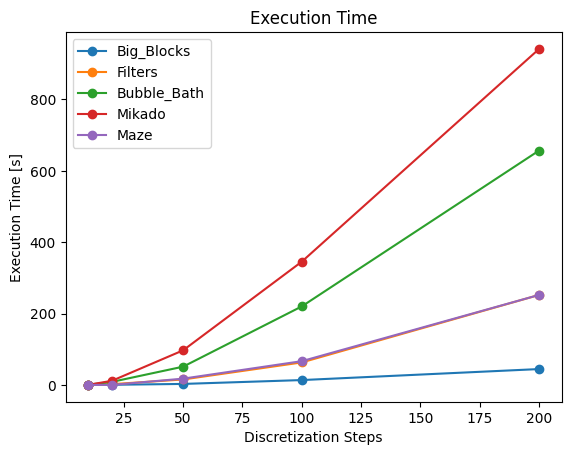

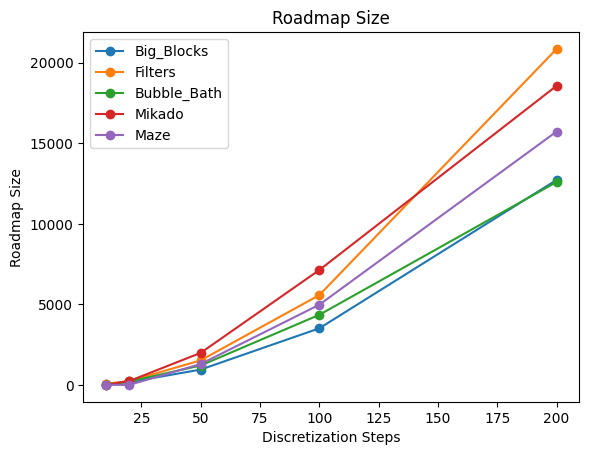

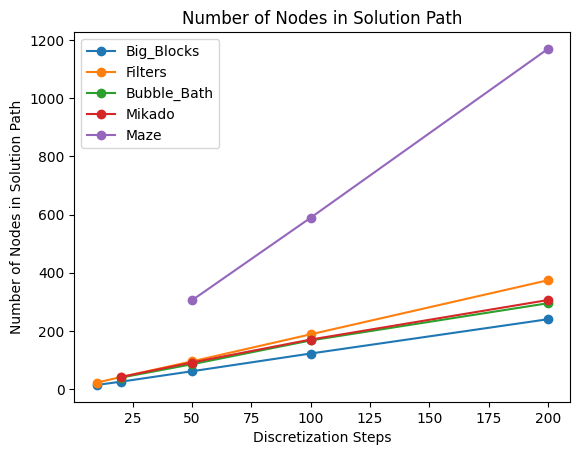

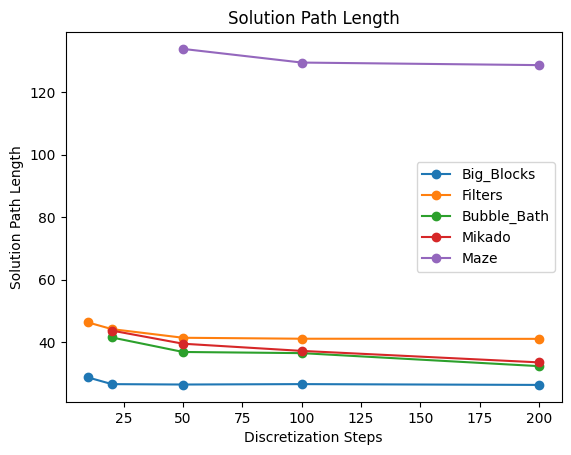

In [24]:
import copy
import matplotlib.pyplot as plt
import numpy as np

disc_values = [10, 20, 50, 100, 200]

configs = []

discretization_config = dict()
discretization_config["w"] = 0.5
discretization_config["heuristic"]  = "euclidean"
discretization_config["reopen"] = True
discretization_config["dof"] = 2
discretization_config["check_connection"] = True
discretization_config["lazy_check_connection"] = True
discretization_config["benchmarks"] = [0, 1, 2, 3, 6]

for discretization_value in disc_values:
    config = copy.deepcopy(discretization_config)
    config["discretization"] = [discretization_value for _ in range(config["dof"])]
    configs.append(config)

results = get_evaluation_results(configs=configs)

plot_results_line(results=results, x_axis_values=disc_values, x_axis_title="Discretization Steps")

Drawing graph took 0.0653 seconds
Drawing obstacles took 0.0018 seconds
Drawing graph took 0.0736 seconds
Drawing obstacles took 0.0137 seconds
Drawing graph took 0.0220 seconds
Drawing obstacles took 0.0651 seconds
Drawing graph took 0.0116 seconds
Drawing obstacles took 0.0679 seconds
Drawing graph took 0.0077 seconds
Drawing obstacles took 0.0328 seconds


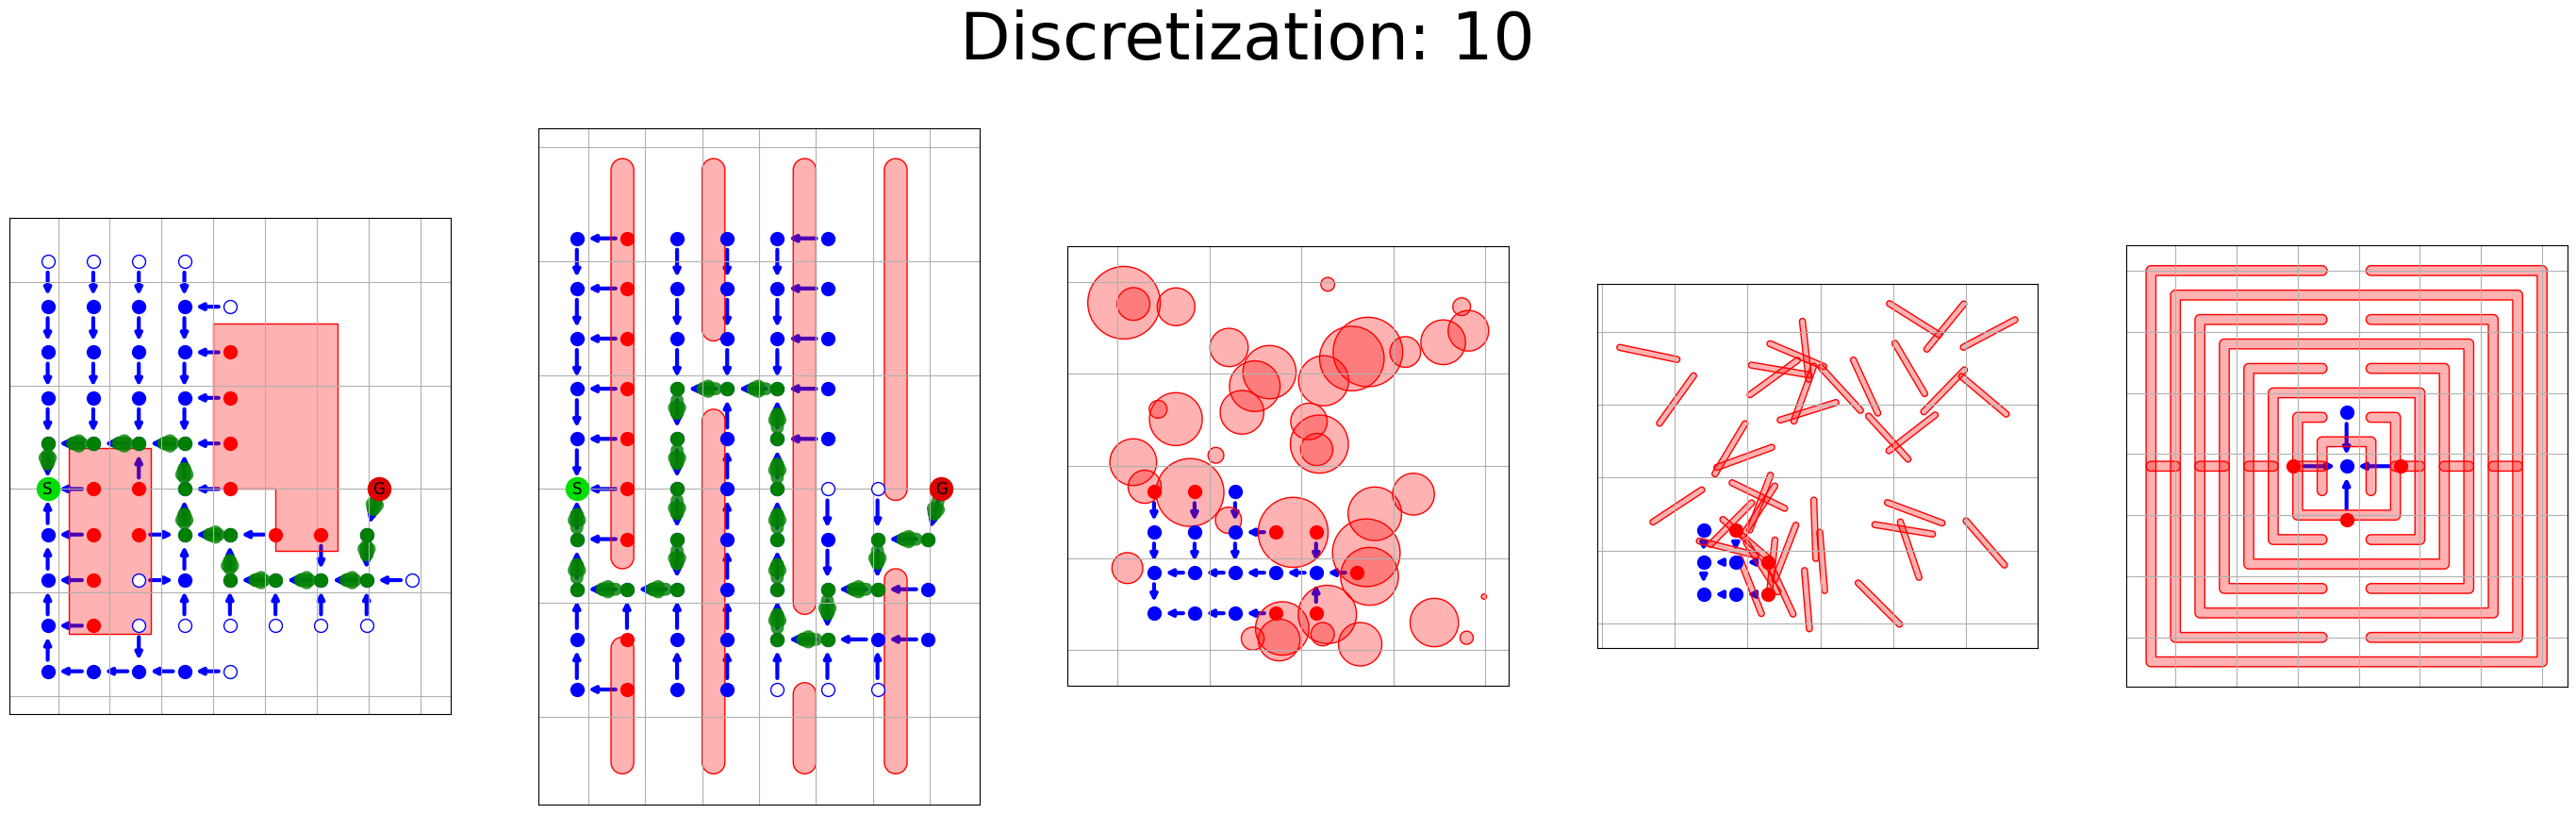

Drawing graph took 0.1904 seconds
Drawing obstacles took 0.0020 seconds
Drawing graph took 0.2487 seconds
Drawing obstacles took 0.0181 seconds
Drawing graph took 0.2299 seconds
Drawing obstacles took 0.0722 seconds
Drawing graph took 0.2580 seconds
Drawing obstacles took 0.0732 seconds
Drawing graph took 0.0110 seconds
Drawing obstacles took 0.0321 seconds


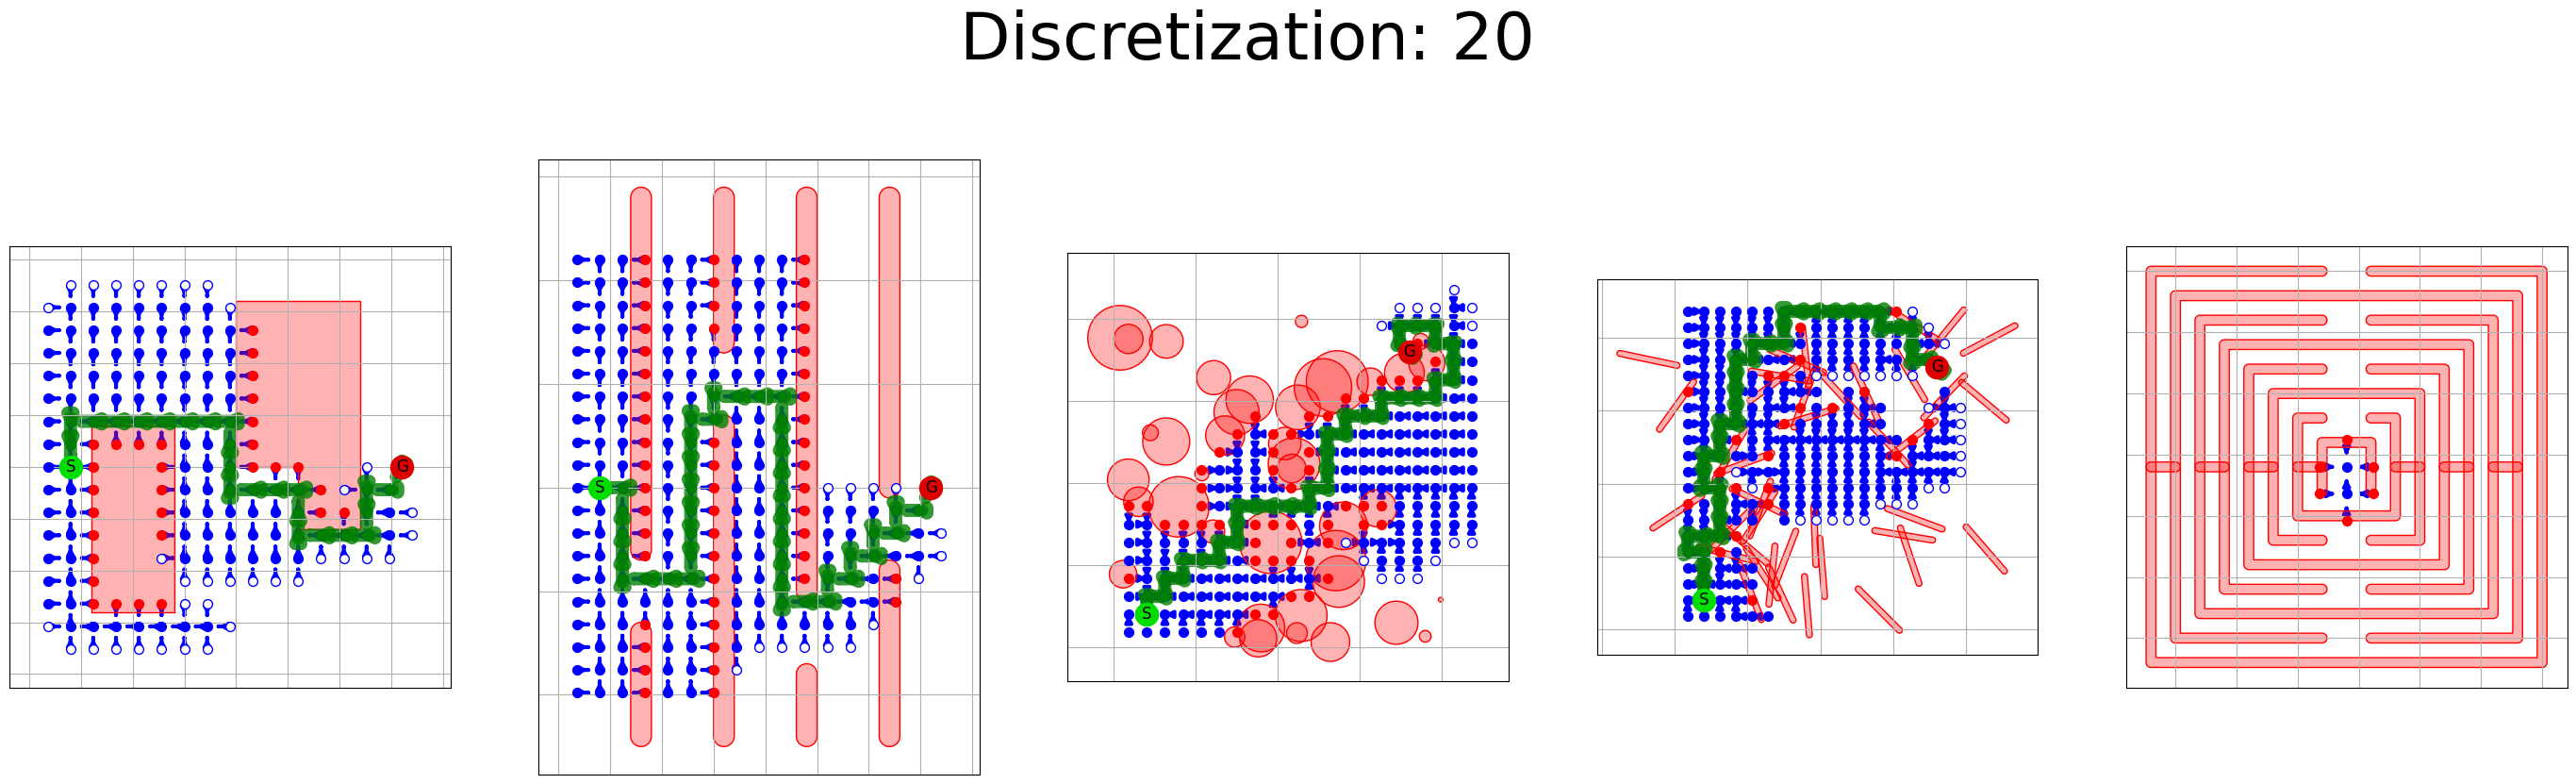

Drawing graph took 0.9221 seconds
Drawing obstacles took 0.0050 seconds
Drawing graph took 1.3078 seconds
Drawing obstacles took 0.0342 seconds
Drawing graph took 0.9873 seconds
Drawing obstacles took 0.1034 seconds
Drawing graph took 1.6390 seconds
Drawing obstacles took 0.1285 seconds
Drawing graph took 1.1652 seconds
Drawing obstacles took 0.0484 seconds


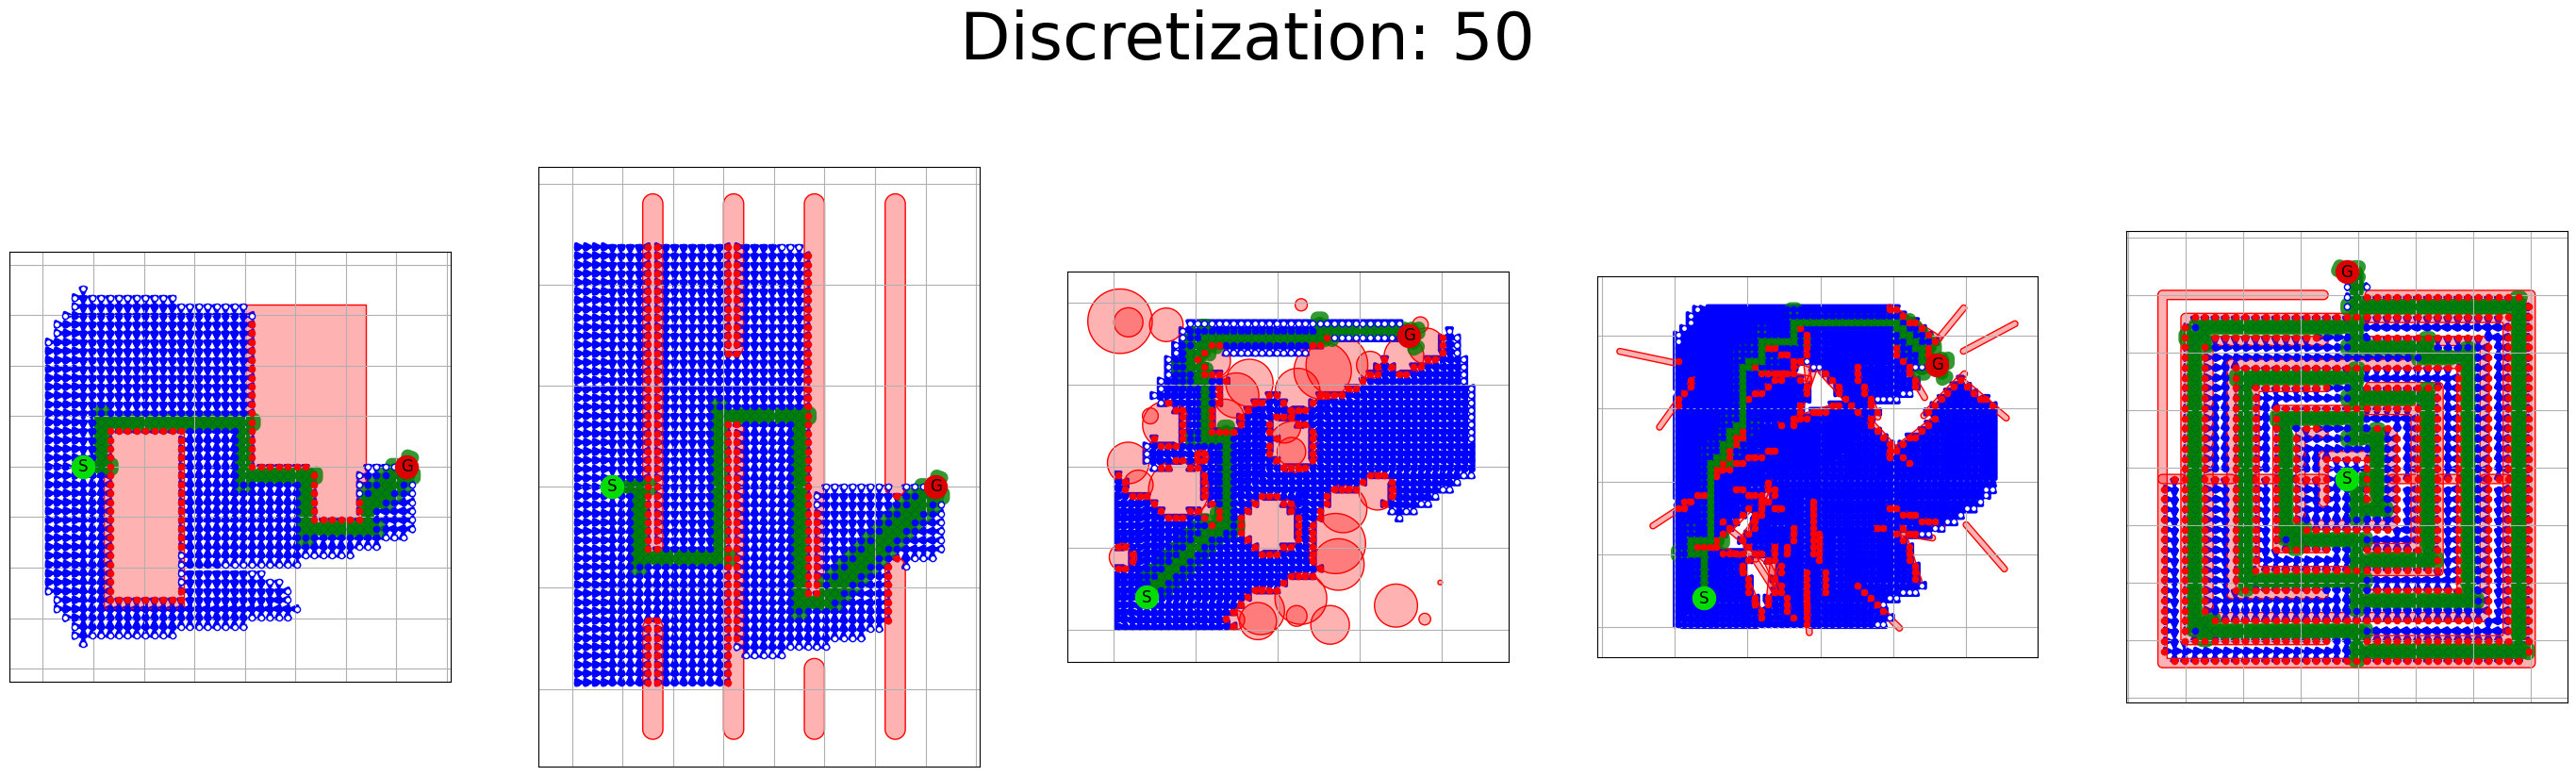

Drawing graph took 2.7689 seconds
Drawing obstacles took 0.0100 seconds
Drawing graph took 7.2193 seconds
Drawing obstacles took 0.0625 seconds
Drawing graph took 2.6599 seconds
Drawing obstacles took 0.2336 seconds
Drawing graph took 4.4069 seconds
Drawing obstacles took 0.4179 seconds
Drawing graph took 3.6511 seconds
Drawing obstacles took 0.1131 seconds


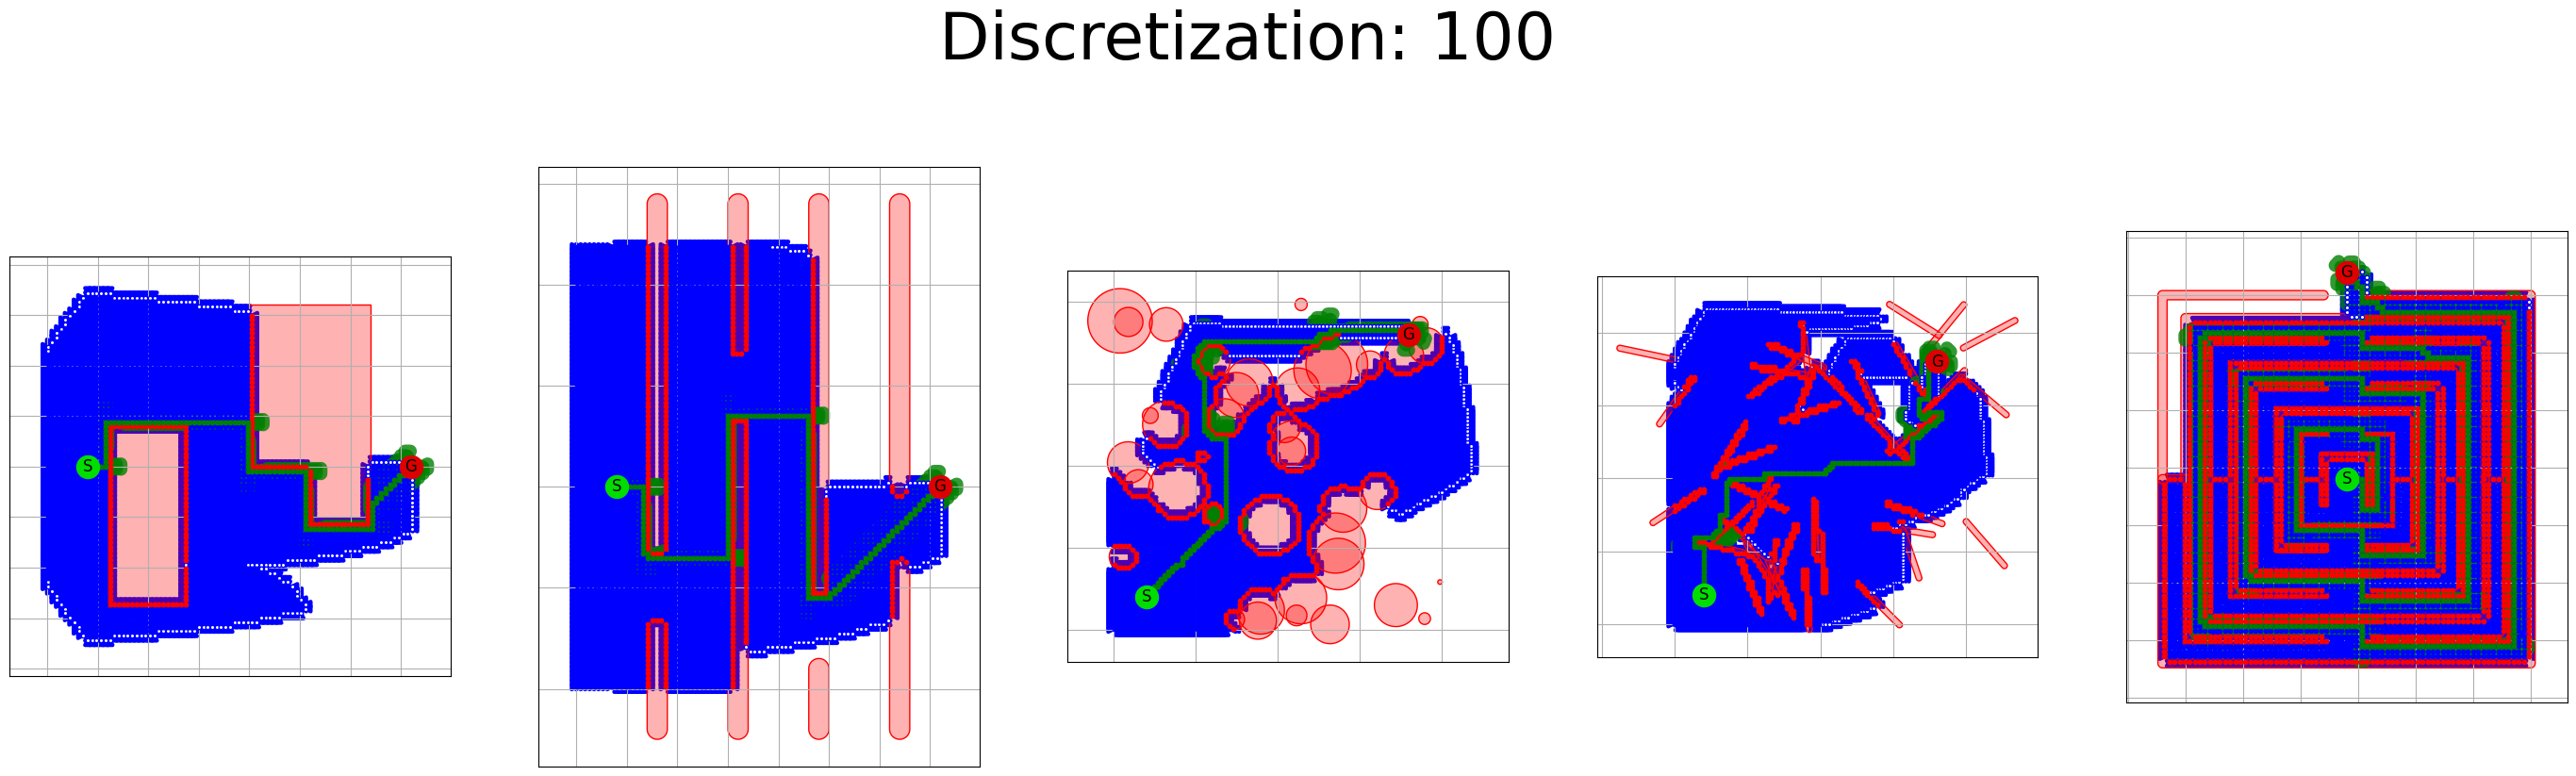

Drawing graph took 12.8455 seconds
Drawing obstacles took 0.0485 seconds
Drawing graph took 16.3953 seconds
Drawing obstacles took 0.2667 seconds
Drawing graph took 7.9049 seconds
Drawing obstacles took 0.7936 seconds
Drawing graph took 15.4477 seconds
Drawing obstacles took 1.2966 seconds
Drawing graph took 9.8482 seconds
Drawing obstacles took 0.3944 seconds


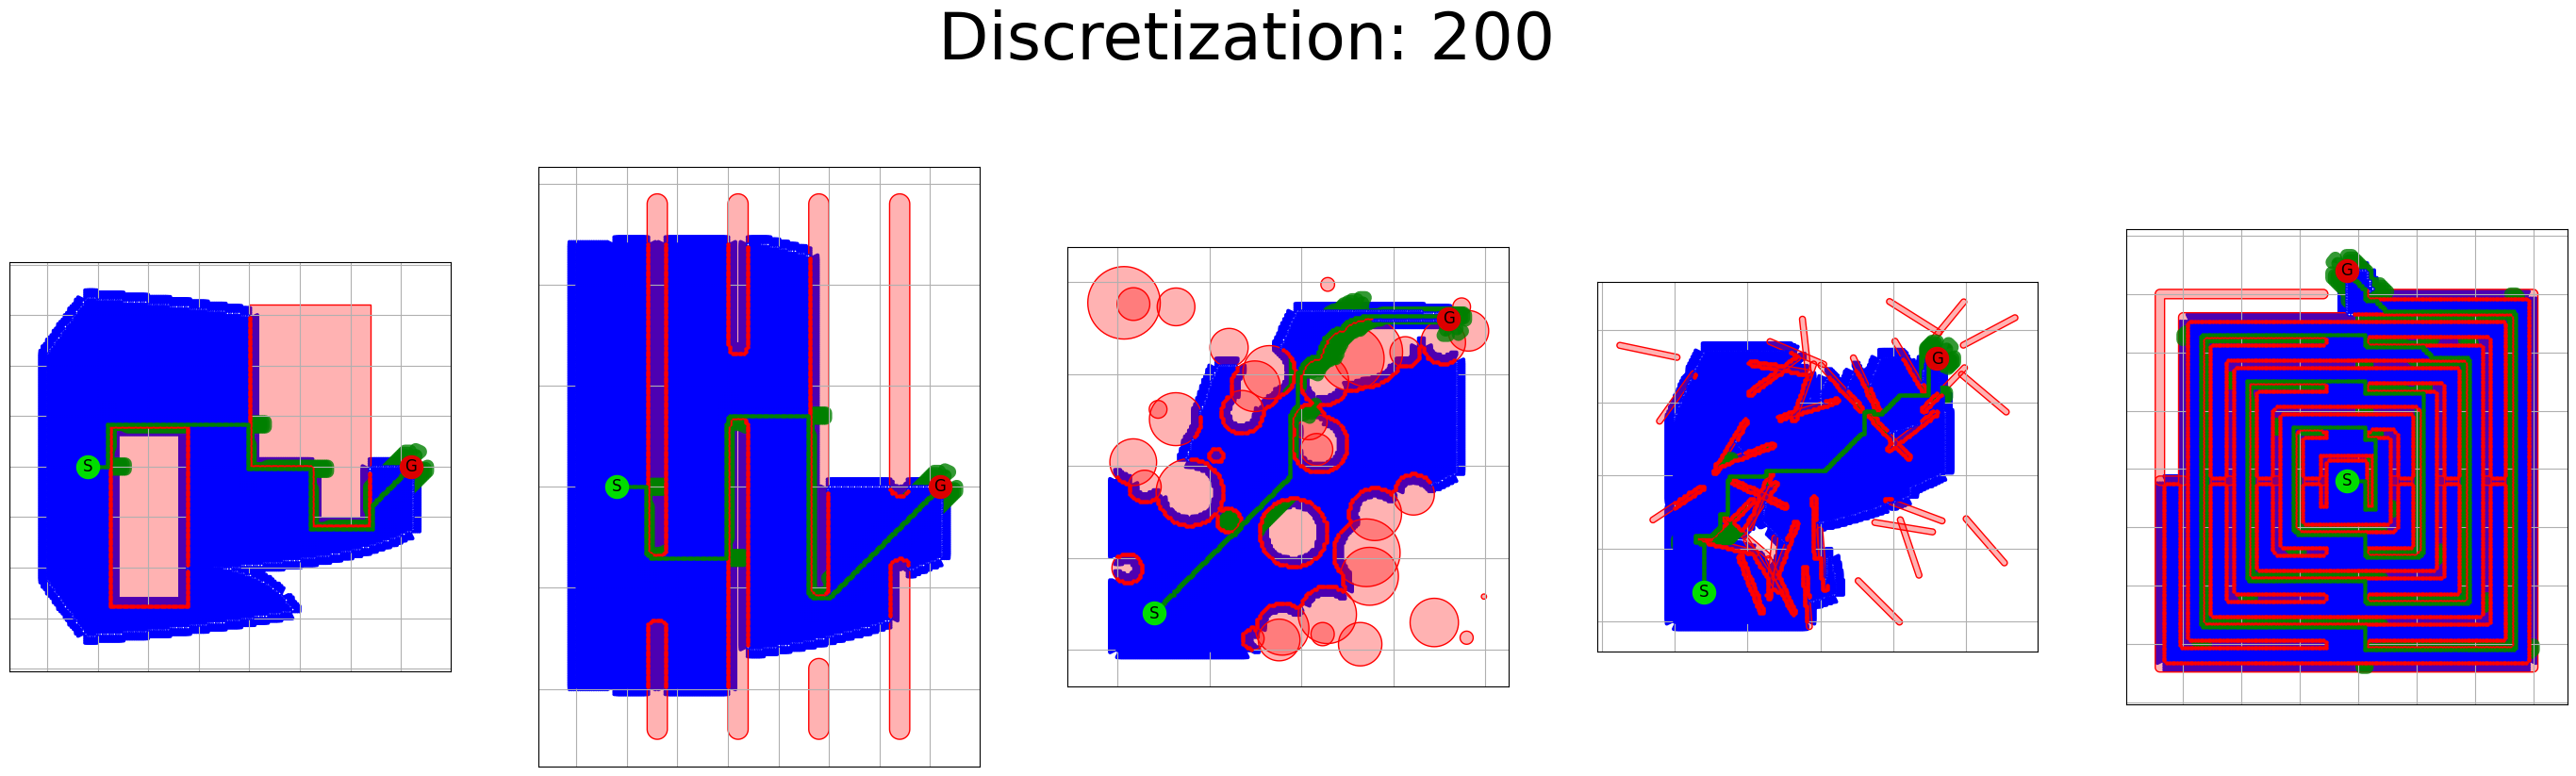

In [25]:
# show results

from IPVISAStar import aStarVisualize

for i, (_, config_results) in enumerate(results):
    fig = plt.figure(figsize=(35,10))
    for j, (bench_name, benchmark_results) in enumerate(config_results.items()):
        astar = benchmark_results["astar"]
        solution = benchmark_results["solution"]
        ax = fig.add_subplot(1,len(config_results.items()),j + 1)
        aStarVisualize(planner=astar, solution=solution, ax=ax, nodeSize=(1000 / disc_values[i]), viz_solution=(len(solution) > 0))
    fig.suptitle(f"Discretization: {disc_values[i]}", fontsize=50)
    plt.show()

### Discussion

Increasing the number of dicretization steps signinficantly increases the execution time. Interestingly the path length only shows significant improvements between low numbers of discretization steps. For larger numbers of discretization steps the relative improvements decrease. This is because with larger numbers of discretization steps only smaller and smaller improvemnts can be gained by staying closer to obstacles. Large improvements only happen, when completely new paths can be found due to the finer discretization. A finer discretization does however enable A* to find solutions for benchmarks that are impossible to solve with a curser dicretization.

## Evaluation: Weight w

In this section we will evaluate the influence of the weight w

----- config 1 of 3 -----
----- benchmark: Big_Blocks -----
----- benchmark: Filters -----
----- benchmark: Bubble_Bath -----
----- benchmark: Mikado -----
----- benchmark: Maze -----
----- config 2 of 3 -----
----- benchmark: Big_Blocks -----
----- benchmark: Filters -----
----- benchmark: Bubble_Bath -----
----- benchmark: Mikado -----
----- benchmark: Maze -----
----- config 3 of 3 -----
----- benchmark: Big_Blocks -----
----- benchmark: Filters -----
----- benchmark: Bubble_Bath -----
----- benchmark: Mikado -----
----- benchmark: Maze -----


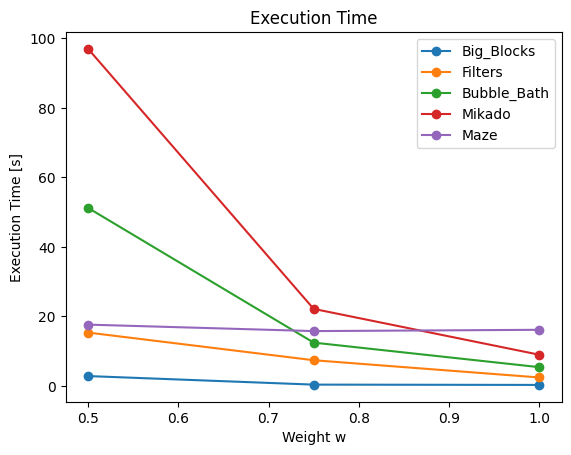

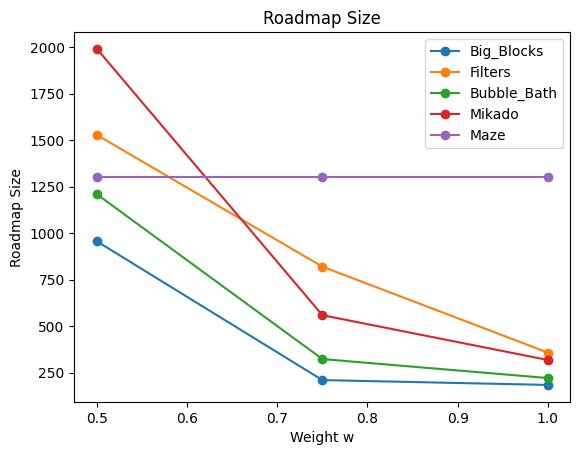

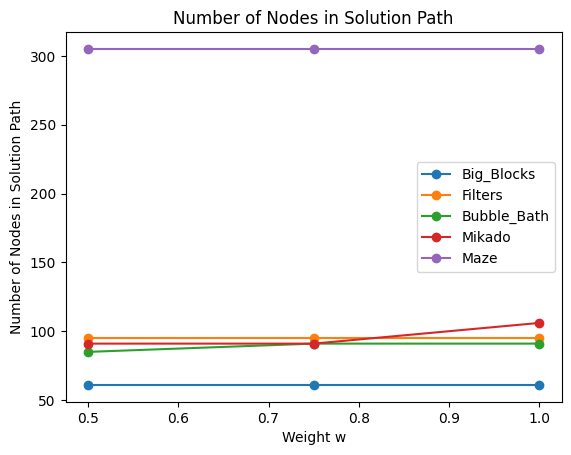

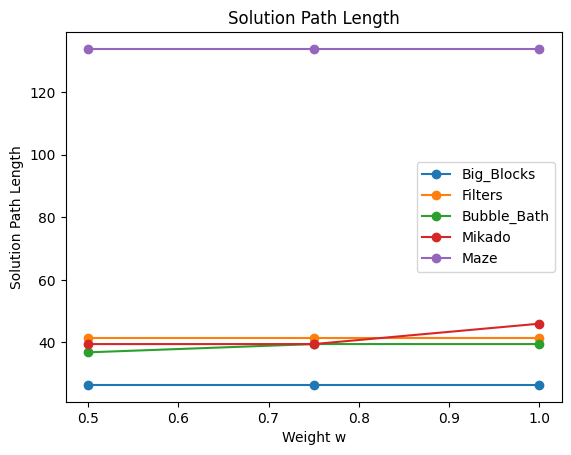

In [26]:
import copy
import matplotlib.pyplot as plt
import numpy as np

w_values = [0.5, 0.75, 1.0]

configs = []

weight_config = dict()
weight_config["heuristic"] = "euclidean"
weight_config["reopen"] = True
weight_config["dof"] = 2
weight_config["discretization"] = [50 for _ in range(weight_config["dof"])]
weight_config["check_connection"] = True
weight_config["lazy_check_connection"] = True
weight_config["benchmarks"] = [0, 1, 2, 3, 6]

for w_value in w_values:
    config = copy.deepcopy(weight_config)
    config["w"] = w_value
    configs.append(config)

results = get_evaluation_results(configs=configs)

plot_results_line(results=results, x_axis_values=w_values, x_axis_title="Weight w")

Drawing graph took 0.9127 seconds
Drawing obstacles took 0.0034 seconds
Drawing graph took 1.3058 seconds
Drawing obstacles took 0.0252 seconds
Drawing graph took 0.9931 seconds
Drawing obstacles took 0.1068 seconds
Drawing graph took 1.6678 seconds
Drawing obstacles took 0.1320 seconds
Drawing graph took 1.1788 seconds
Drawing obstacles took 0.0490 seconds


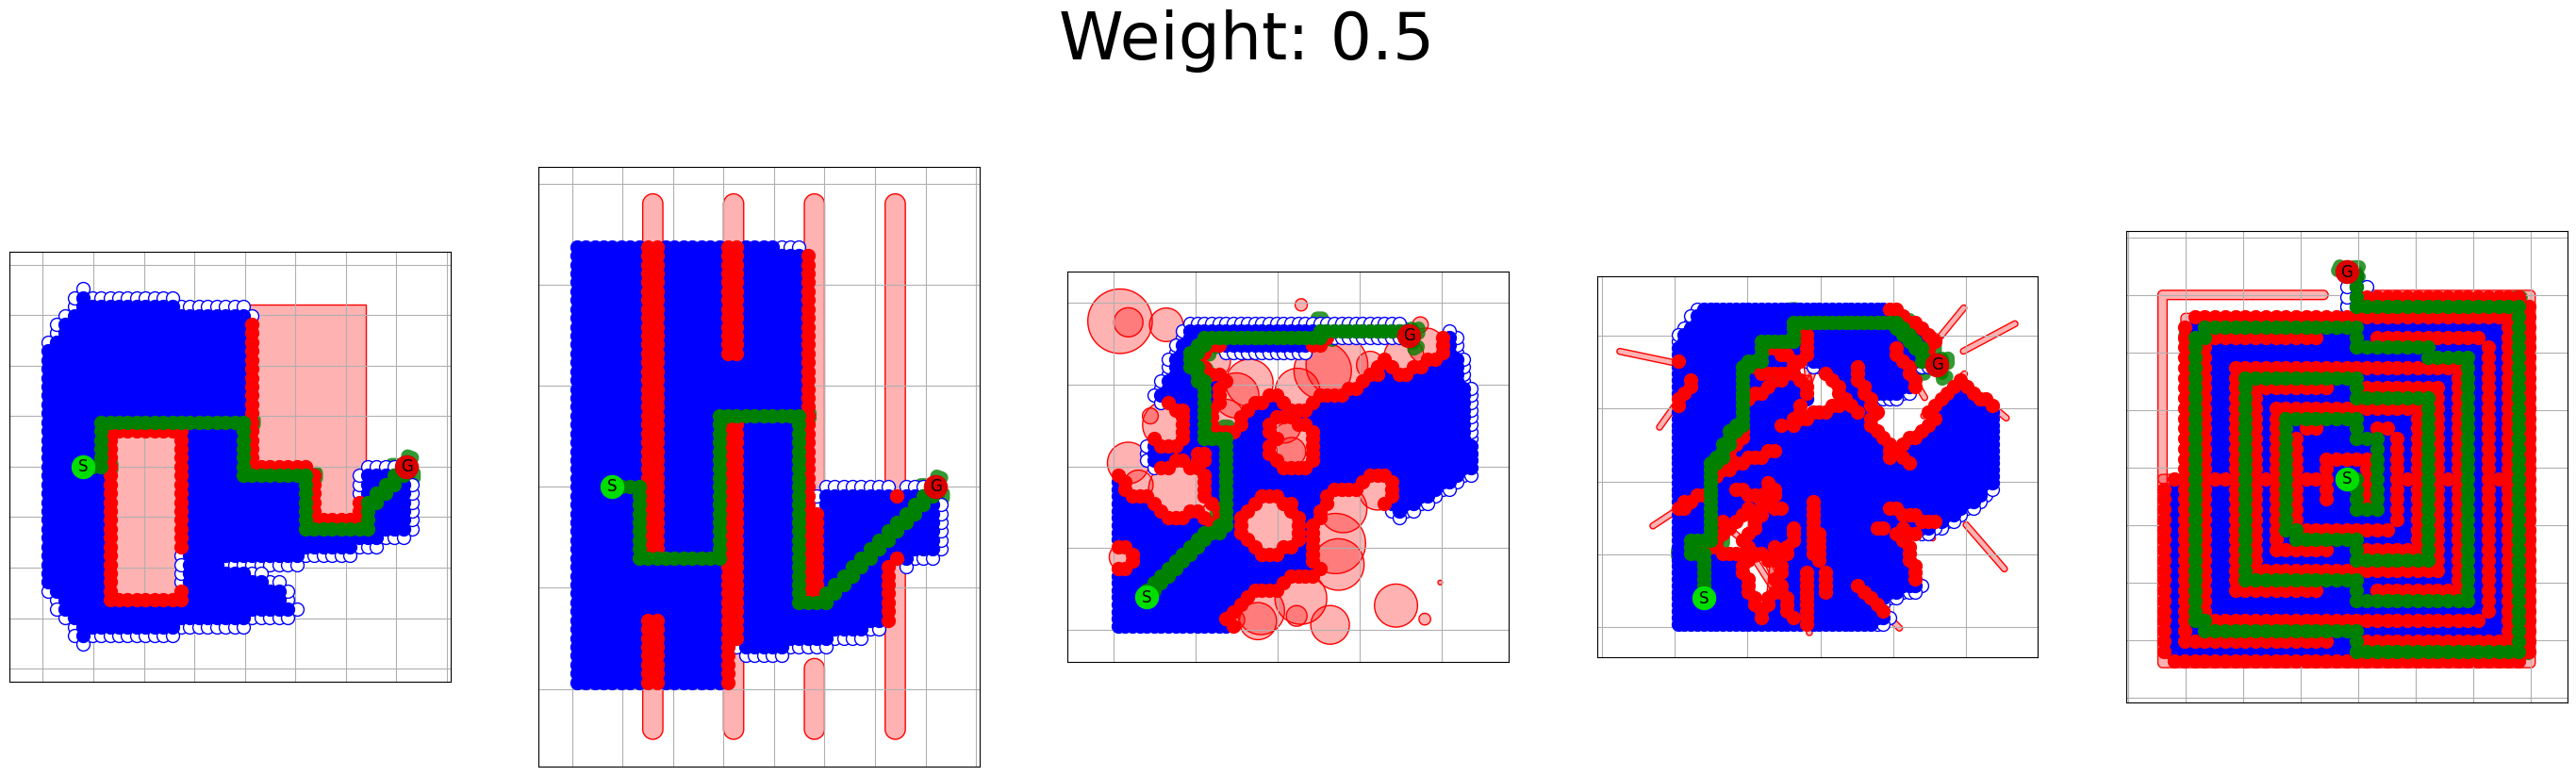

Drawing graph took 0.2056 seconds
Drawing obstacles took 0.0020 seconds
Drawing graph took 0.7869 seconds
Drawing obstacles took 0.0187 seconds
Drawing graph took 0.2661 seconds
Drawing obstacles took 0.0741 seconds
Drawing graph took 0.4597 seconds
Drawing obstacles took 0.0863 seconds
Drawing graph took 1.2161 seconds
Drawing obstacles took 0.0504 seconds


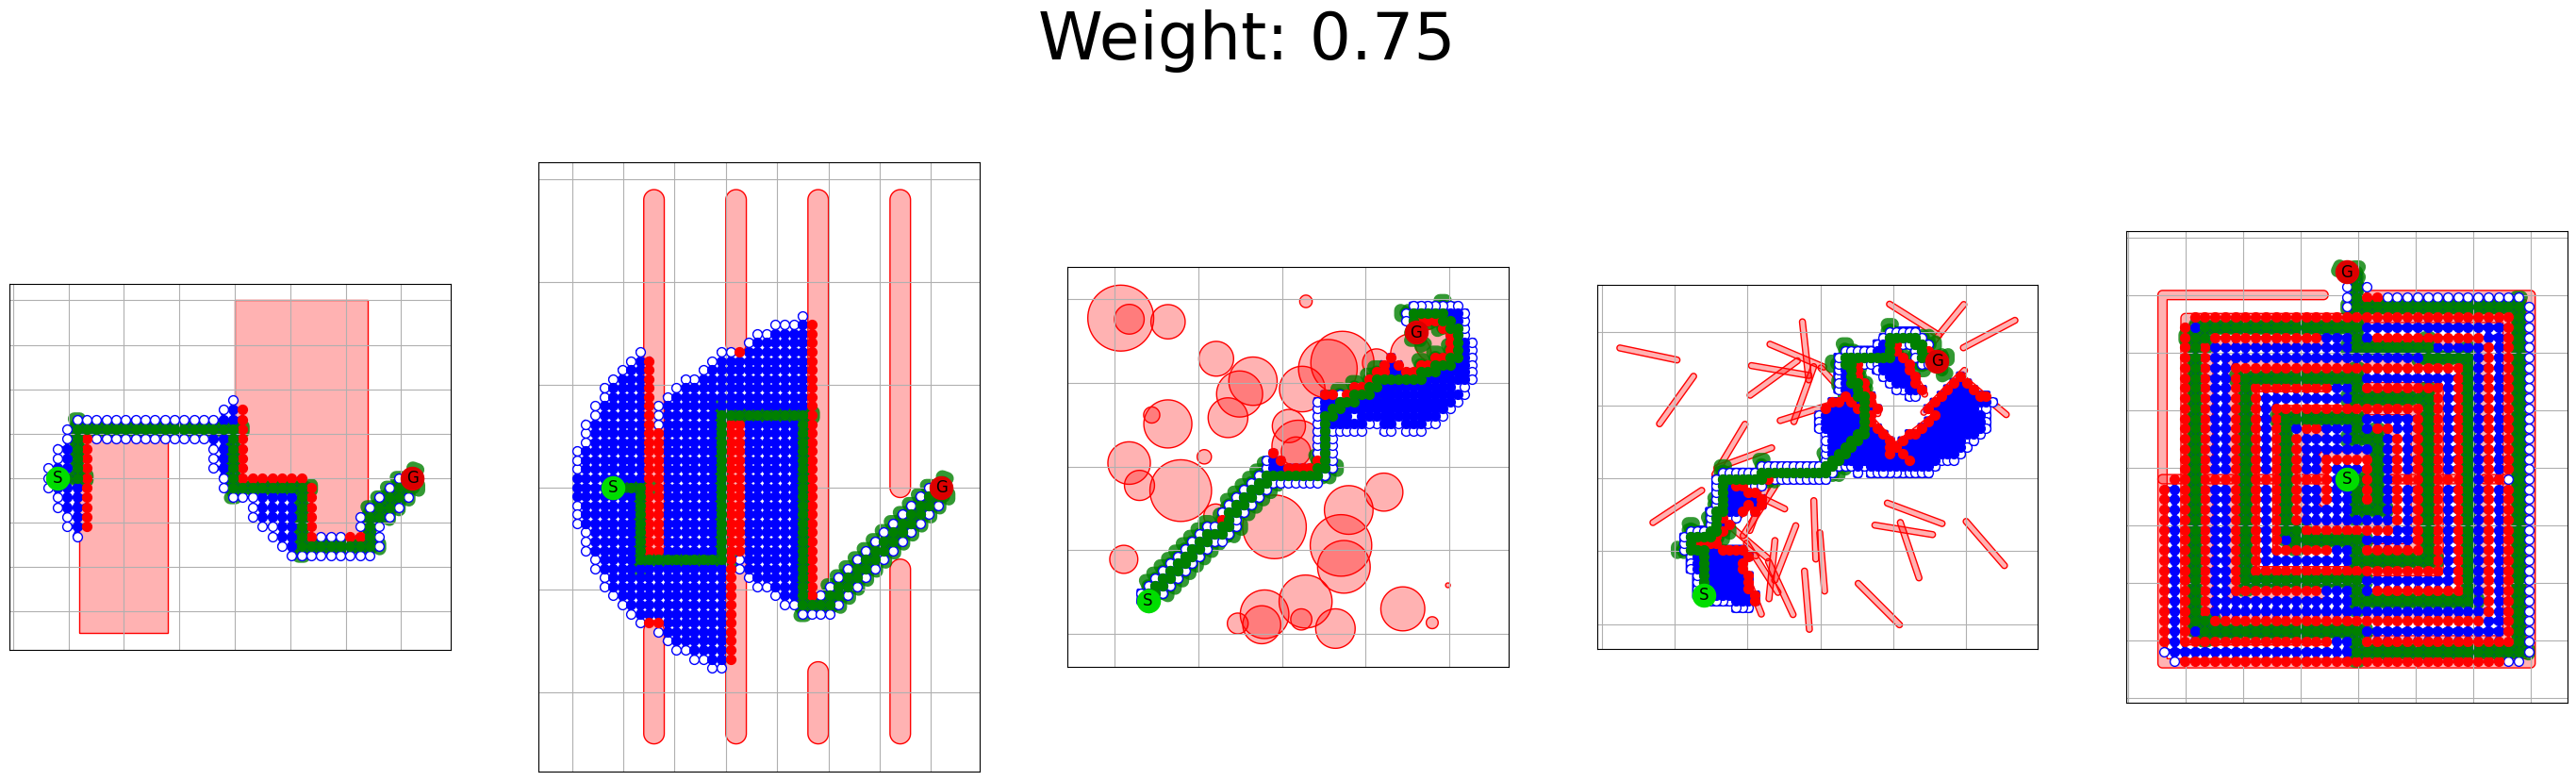

Drawing graph took 0.1785 seconds
Drawing obstacles took 0.0020 seconds
Drawing graph took 0.3212 seconds
Drawing obstacles took 0.0154 seconds
Drawing graph took 0.1838 seconds
Drawing obstacles took 0.0707 seconds
Drawing graph took 0.2915 seconds
Drawing obstacles took 0.0749 seconds
Drawing graph took 1.1636 seconds
Drawing obstacles took 0.0498 seconds


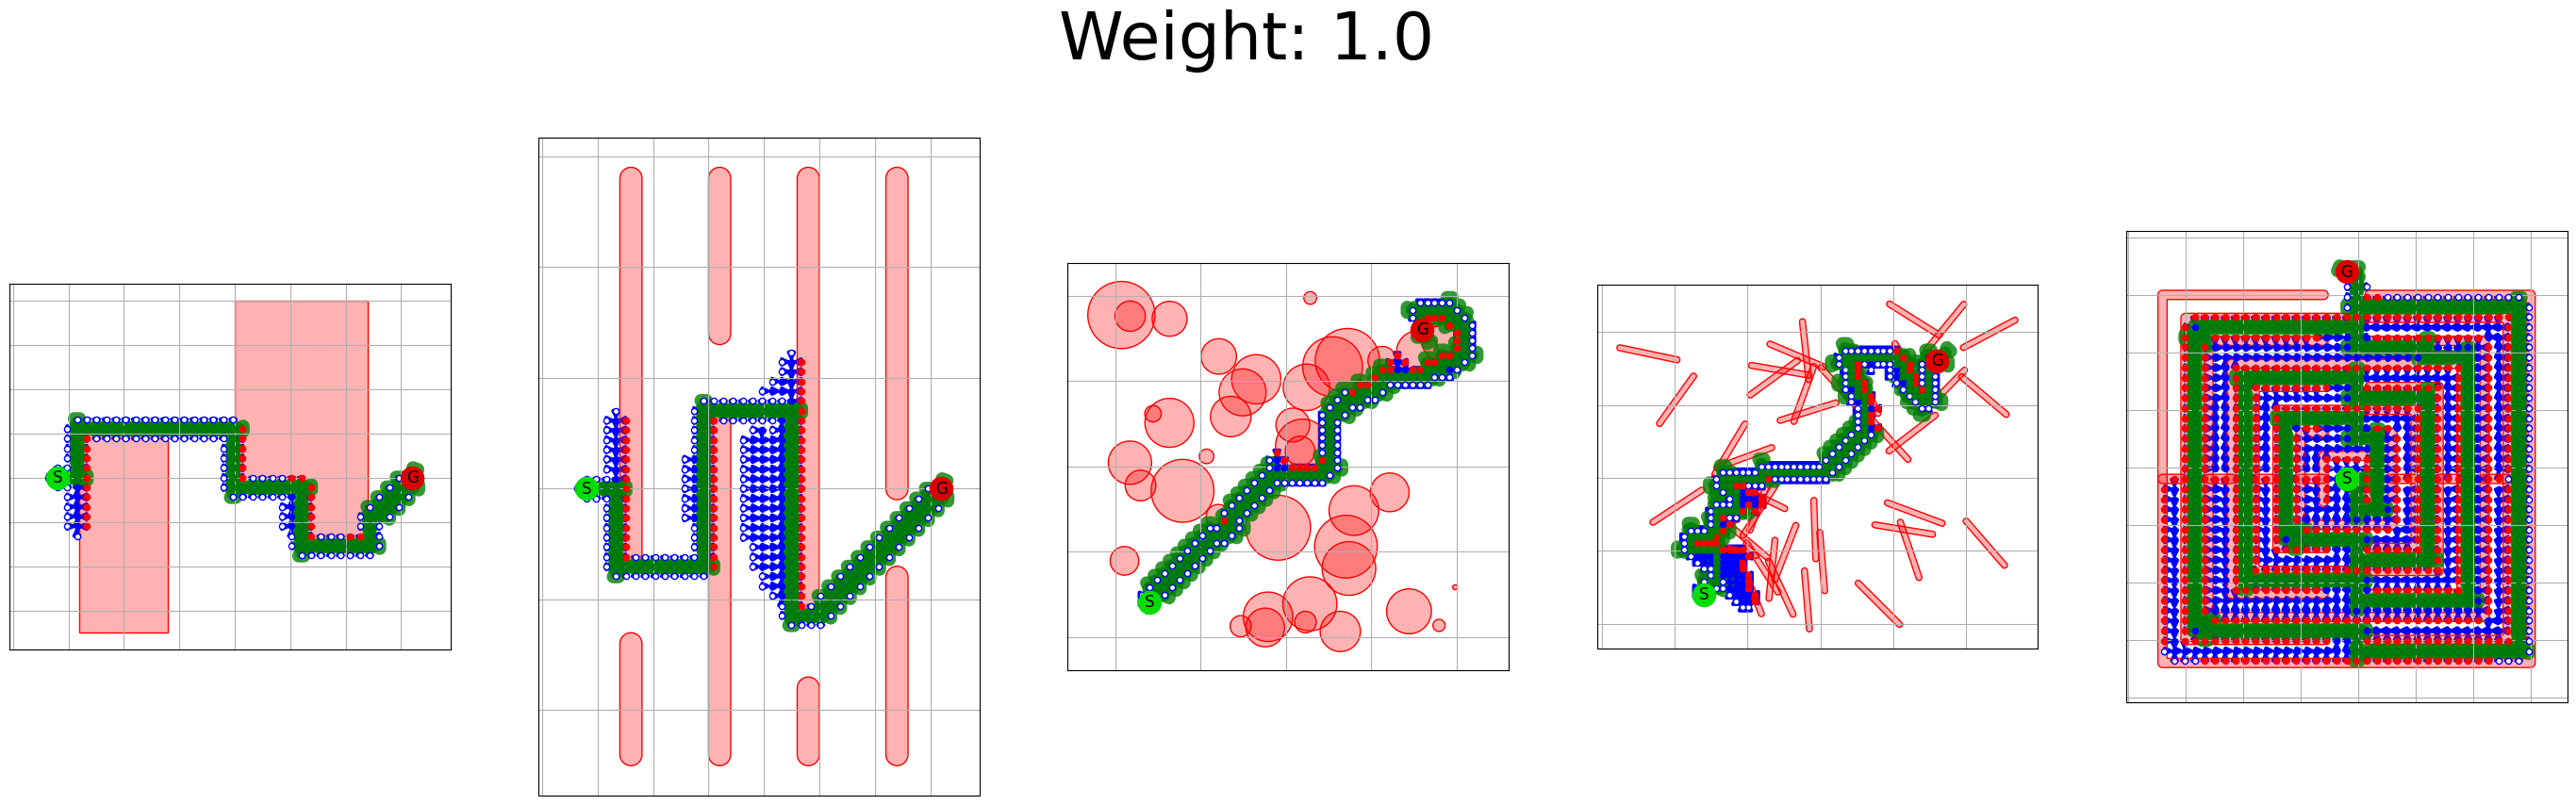

In [27]:
# show results

from IPVISAStar import aStarVisualize

for i, (_, config_results) in enumerate(results):
    fig = plt.figure(figsize=(35,10))
    for j, (bench_name, benchmark_results) in enumerate(config_results.items()):
        astar = benchmark_results["astar"]
        solution = benchmark_results["solution"]
        ax = fig.add_subplot(1,len(config_results.items()),j + 1)
        aStarVisualize(planner=astar, solution=solution, ax=ax, nodeSize=(1000 / disc_values[i]), viz_solution=(len(solution) > 0))
    fig.suptitle(f"Weight: {w_values[i]}", fontsize=50)
    plt.show()

### Discussion

While a higher weight factor w causes some increases in number of nodes in the solution path the decrease in roadmap size is much more significant. This means that increasing the weight factor w is an effective tool to increase the search efficiency with only small drawbacks in some cases (e.g. trap near the start of the mikado benchmark).

## Evaluation: Line Collision

In this section we will evaluate the influence of line collision detection

----- config 1 of 2 -----
----- benchmark: Big_Blocks -----
----- benchmark: Filters -----
----- benchmark: Bubble_Bath -----
----- benchmark: Mikado -----
----- benchmark: Maze -----
----- config 2 of 2 -----
----- benchmark: Big_Blocks -----
----- benchmark: Filters -----
----- benchmark: Bubble_Bath -----
----- benchmark: Mikado -----
----- benchmark: Maze -----


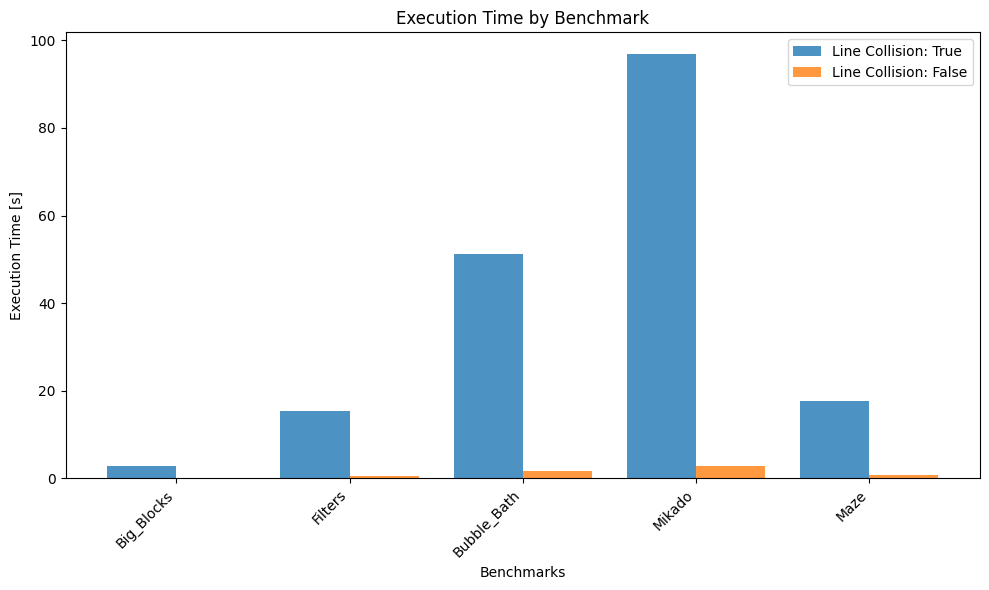

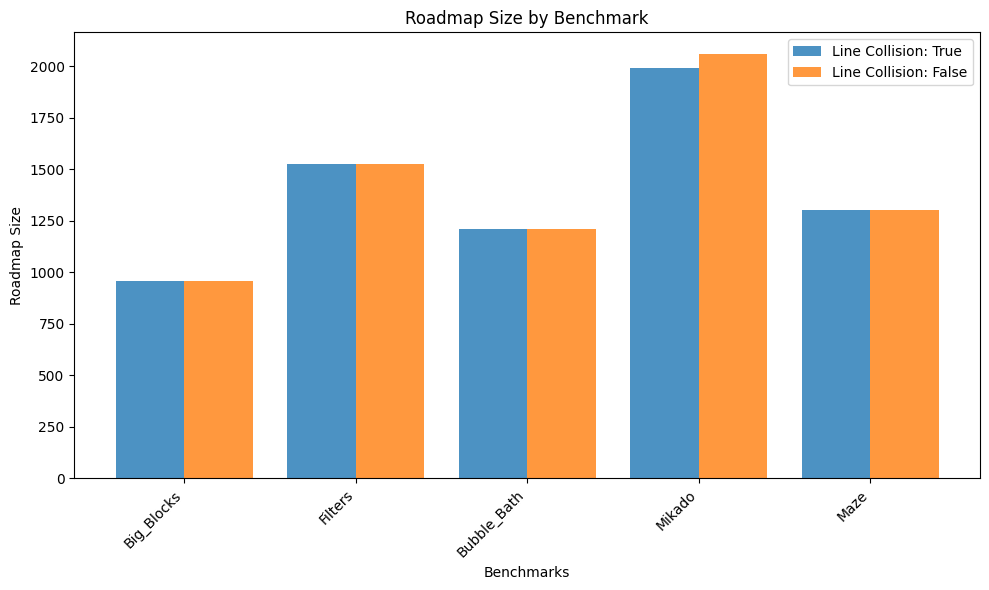

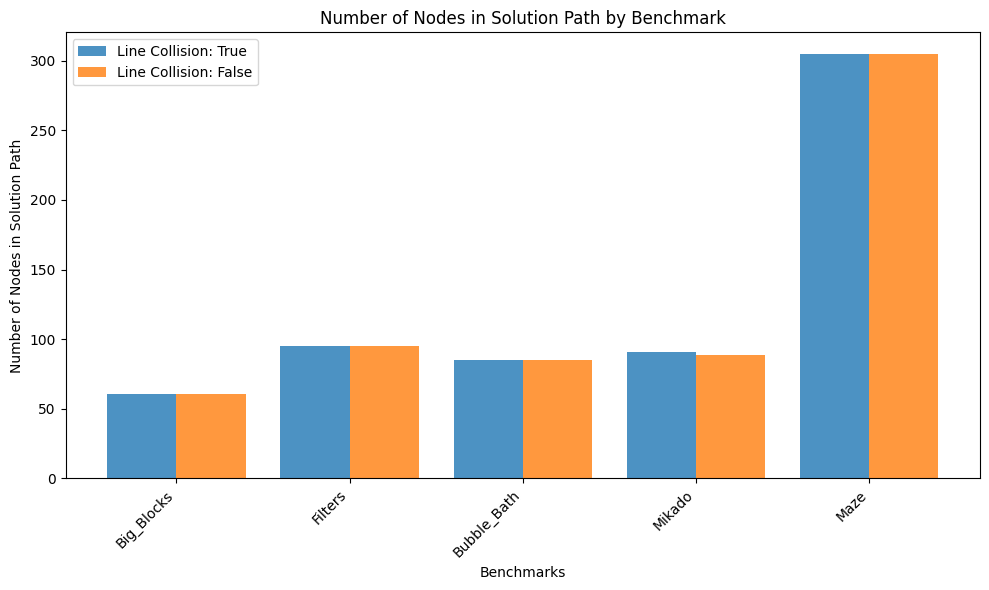

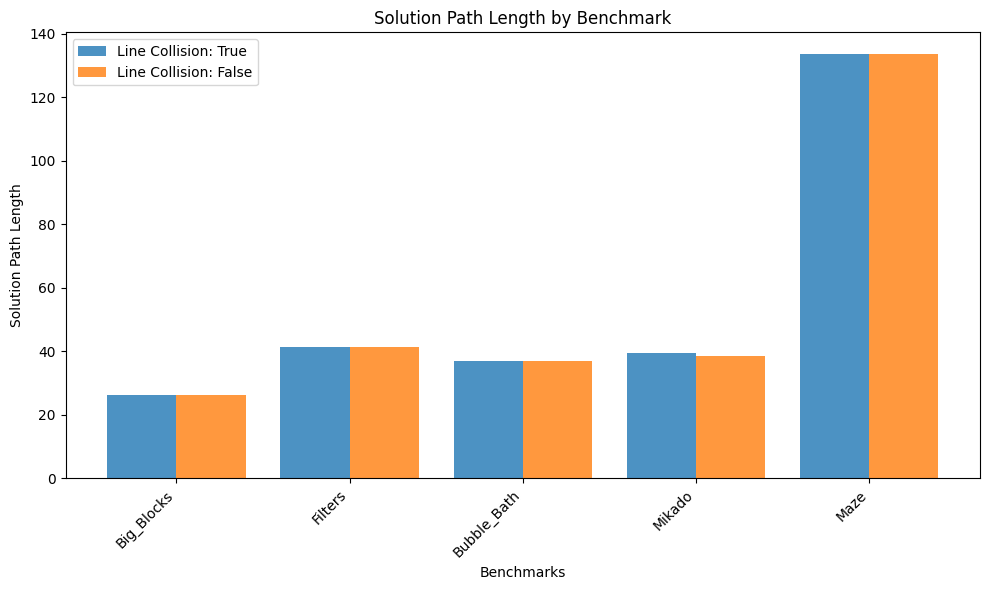

In [28]:
import copy
import matplotlib.pyplot as plt
import numpy as np

w_values = [0.5, 0.75, 1.0]

configs = []

line_coll_config = dict()
line_coll_config["heuristic"] = "euclidean"
line_coll_config["reopen"] = True
line_coll_config["dof"] = 2
line_coll_config["discretization"] = [50 for _ in range(line_coll_config["dof"])]
line_coll_config["w"] = .5
line_coll_config["benchmarks"] = [0, 1, 2, 3, 6]

config = copy.deepcopy(line_coll_config)
config["check_connection"] = True
config["lazy_check_connection"] = True
configs.append(config)

config = copy.deepcopy(line_coll_config)
config["check_connection"] = False
config["lazy_check_connection"] = False
configs.append(config)

results = get_evaluation_results(configs=configs)

plot_results_bar(results=results, x_axis_values=[True, False], x_axis_title="Line Collision")

Drawing graph took 0.9054 seconds
Drawing obstacles took 0.0041 seconds
Drawing graph took 1.3181 seconds
Drawing obstacles took 0.0267 seconds
Drawing graph took 1.0155 seconds
Drawing obstacles took 0.1037 seconds
Drawing graph took 1.6612 seconds
Drawing obstacles took 0.1431 seconds
Drawing graph took 1.1879 seconds
Drawing obstacles took 0.0628 seconds


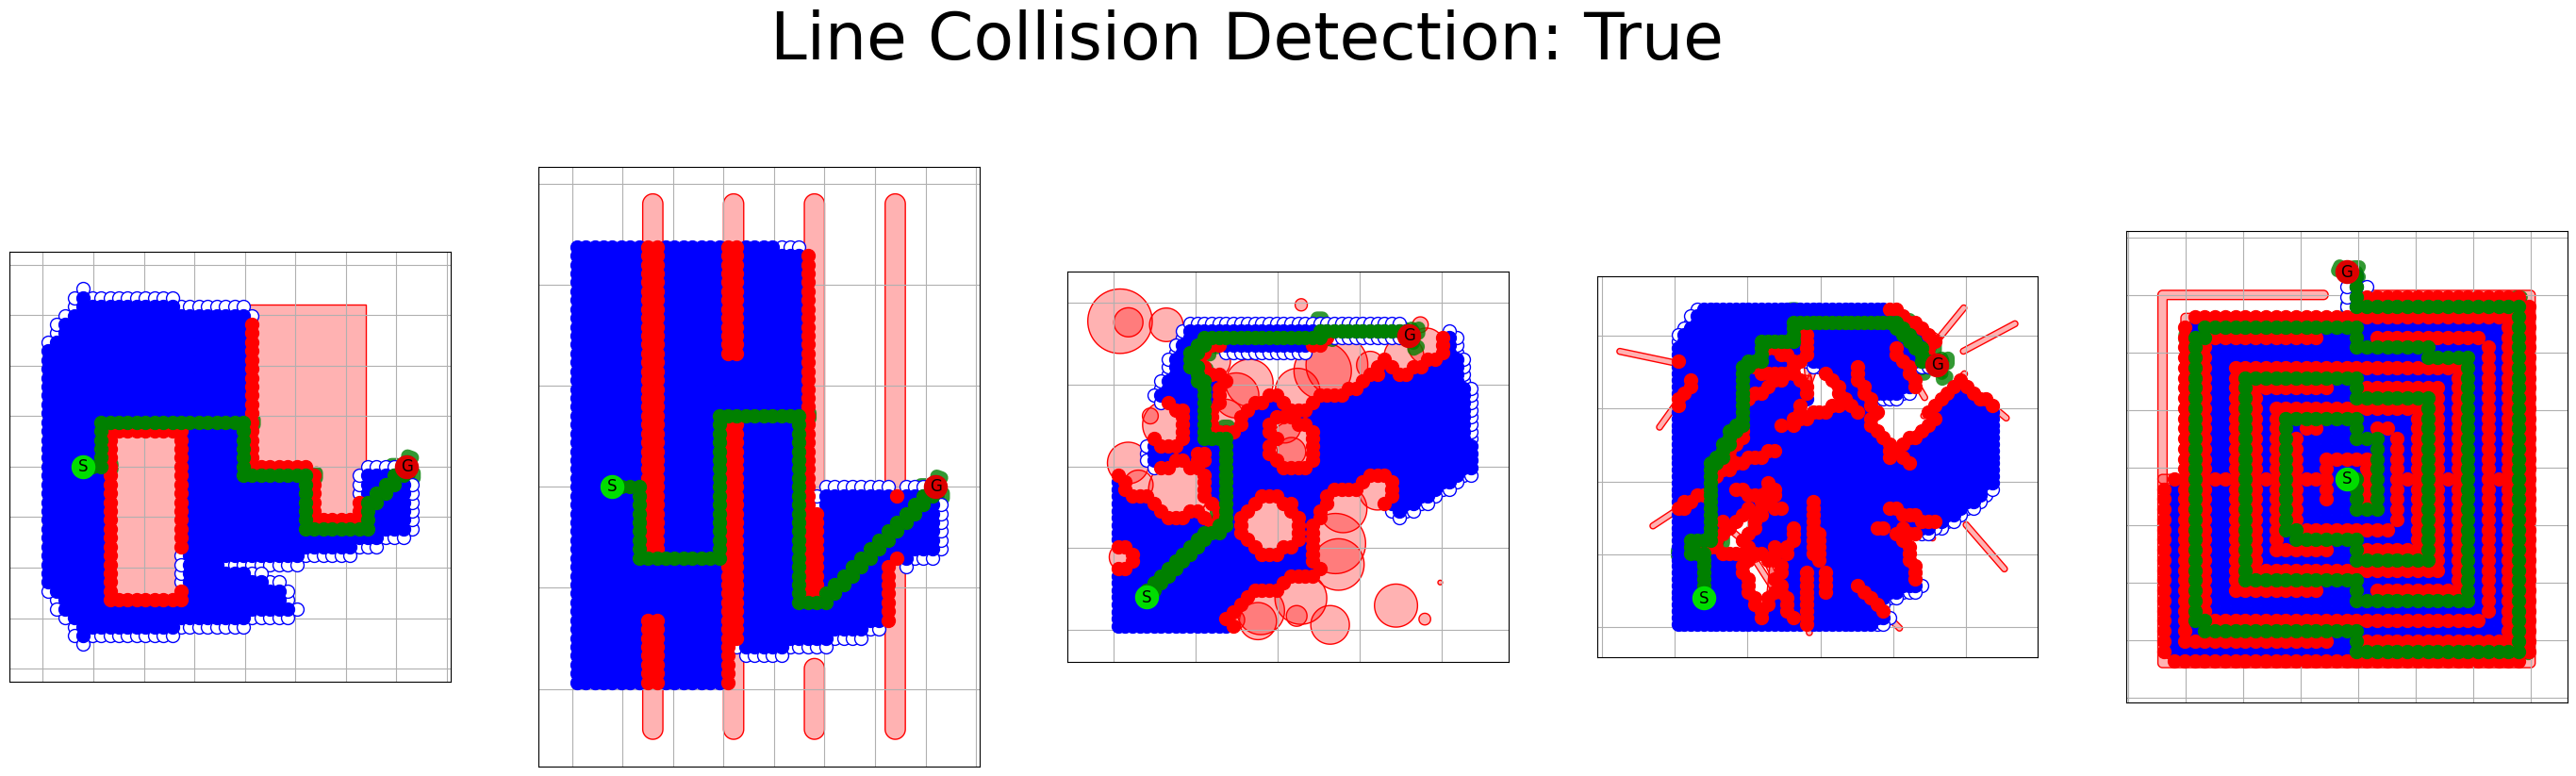

Drawing graph took 0.8782 seconds
Drawing obstacles took 0.0035 seconds
Drawing graph took 1.2639 seconds
Drawing obstacles took 0.0261 seconds
Drawing graph took 0.9959 seconds
Drawing obstacles took 0.1025 seconds
Drawing graph took 1.7101 seconds
Drawing obstacles took 0.1328 seconds
Drawing graph took 1.1639 seconds
Drawing obstacles took 0.0535 seconds


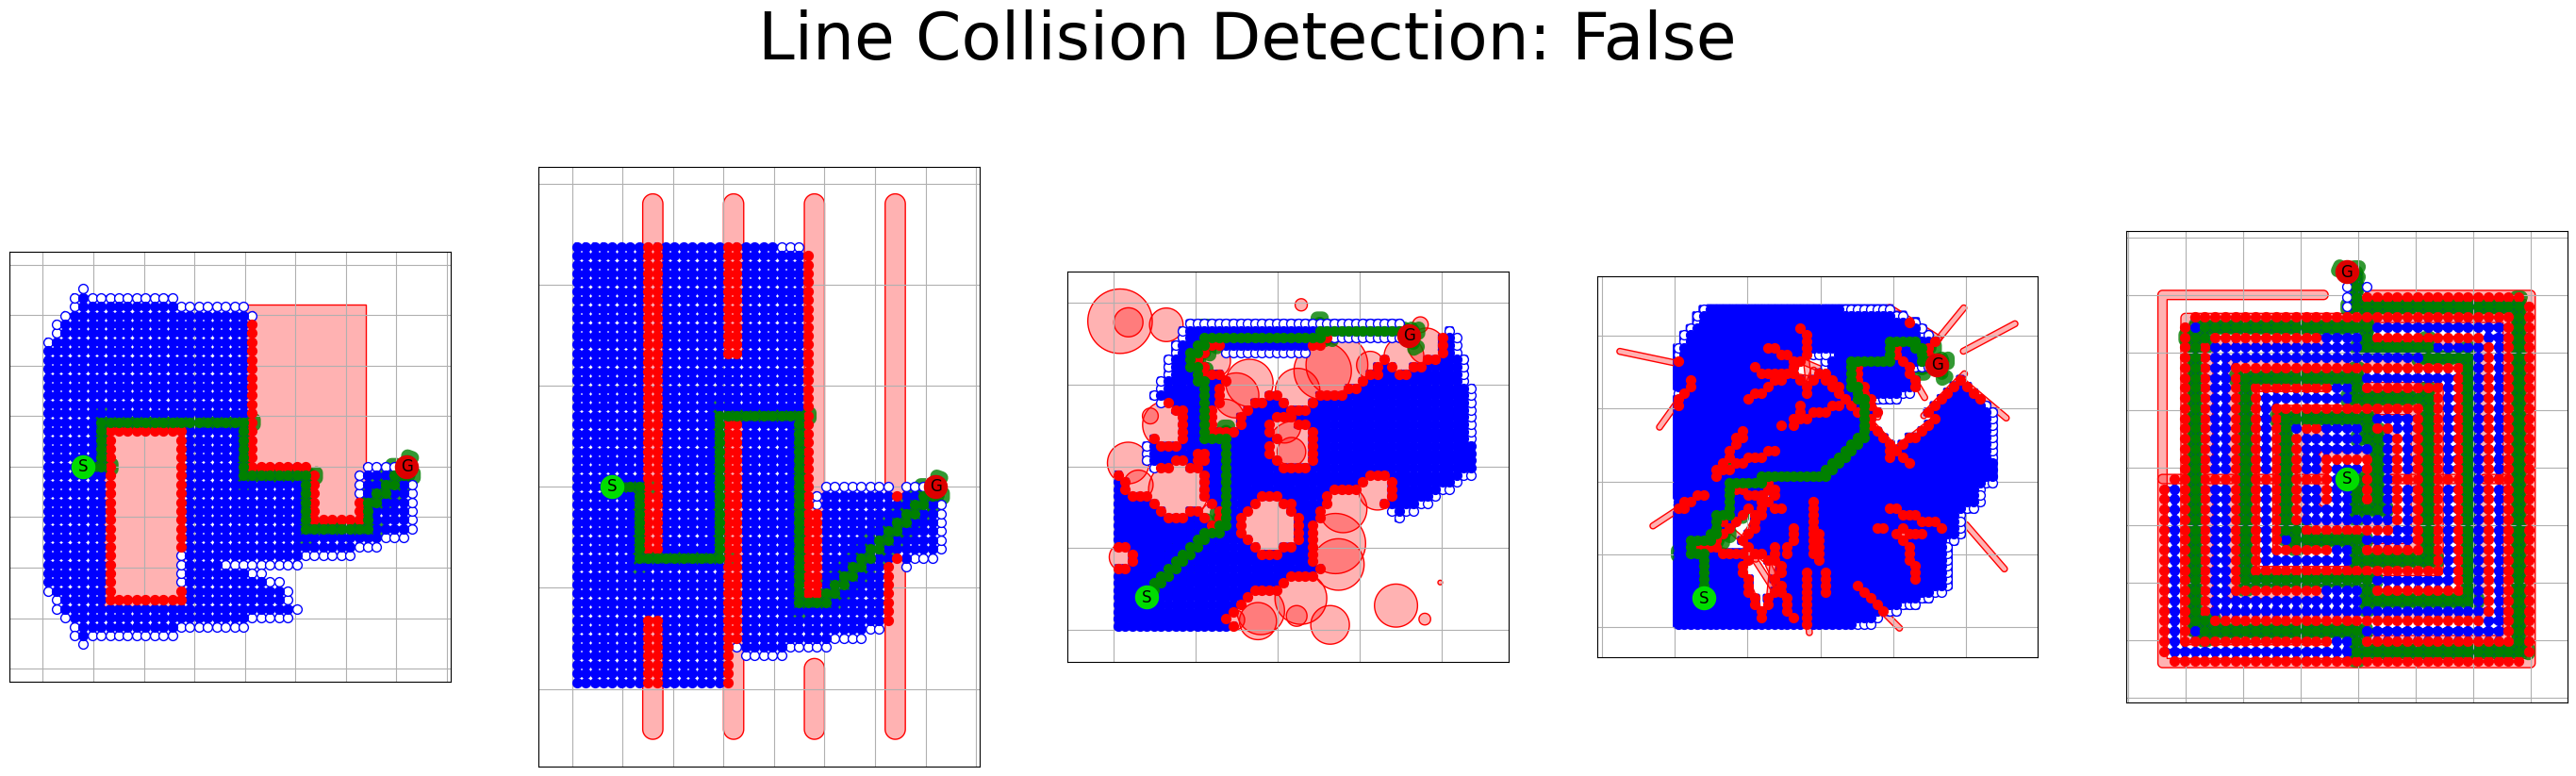

In [29]:
# show results

from IPVISAStar import aStarVisualize

activation_values = [True, False]

for i, (_, config_results) in enumerate(results):
    fig = plt.figure(figsize=(35,10))
    for j, (bench_name, benchmark_results) in enumerate(config_results.items()):
        astar = benchmark_results["astar"]
        solution = benchmark_results["solution"]
        ax = fig.add_subplot(1,len(config_results.items()),j + 1)
        aStarVisualize(planner=astar, solution=solution, ax=ax, nodeSize=(1000 / disc_values[i]), viz_solution=(len(solution) > 0))
    fig.suptitle(f"Line Collision Detection: {activation_values[i]}", fontsize=50)
    plt.show()

### Discussion

Enabling line collision detection leads to a significant increas in execution time. However, line collision can prevent incorrect solutions that lead to collisions with obstacles. When comparing the execution time of enabeling line collision detection and increasing the number of dicretization steps to a point where obstacle collisions are prevented in our benchmarks, we conclude that increasing the number of discretization steps is more efficient. But if the size of obstacles in your configuration space is unknown, enabling line collision detection can still be worthwile

## Evaluation: Reopening

In this section we will evaluate the influence of reopening

----- config 1 of 2 -----
----- benchmark: Big_Blocks -----
----- benchmark: Filters -----
----- benchmark: Bubble_Bath -----
----- benchmark: Mikado -----
----- benchmark: Maze -----
----- config 2 of 2 -----
----- benchmark: Big_Blocks -----


/home/simon/miniconda3/envs/ir/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


Iteration 100
----- benchmark: Filters -----


/home/simon/miniconda3/envs/ir/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
----- benchmark: Bubble_Bath -----
Iteration 100
----- benchmark: Mikado -----
Iteration 100
Iteration 200
Iteration 300
----- benchmark: Maze -----
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 500Candidate -1--12- with cost 53.67999999999979 found as alternative parent.
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200


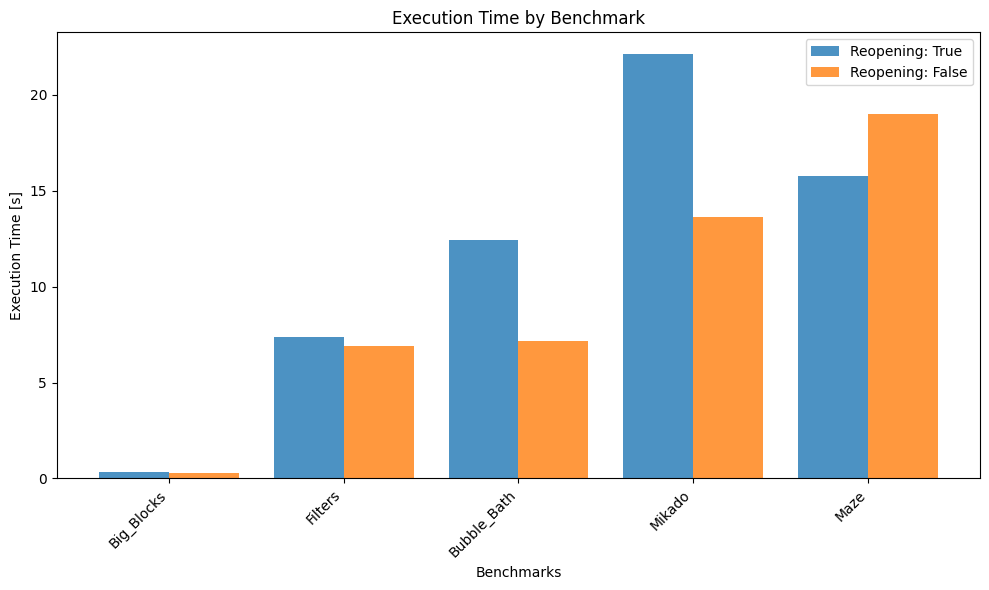

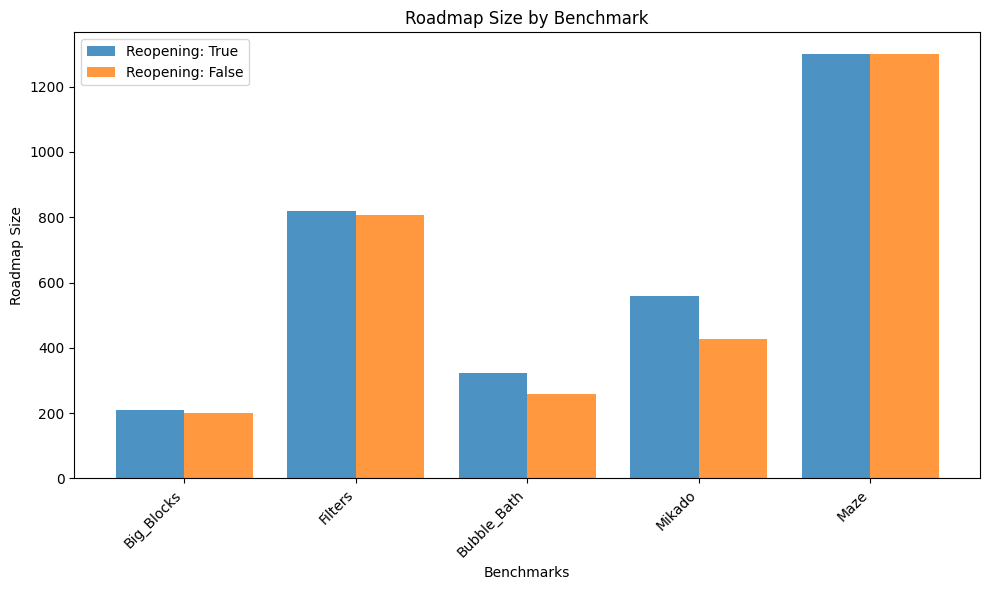

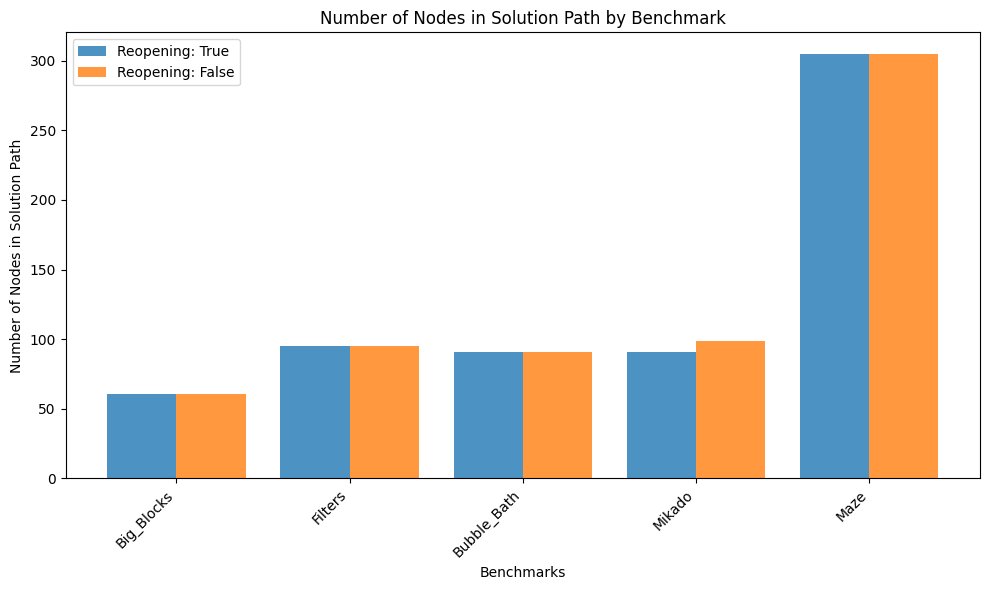

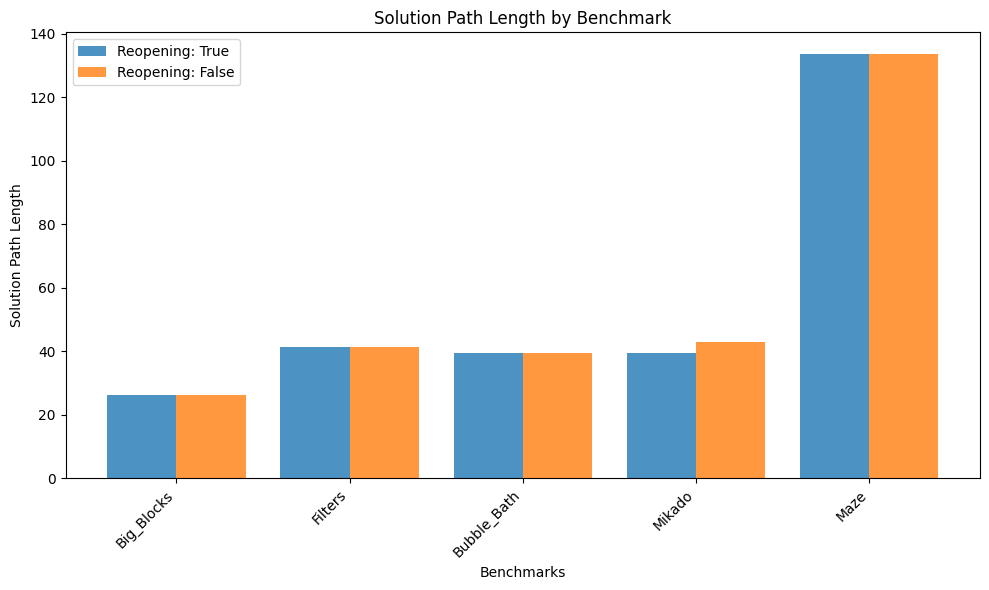

In [32]:
import copy
import matplotlib.pyplot as plt
import numpy as np

w_values = [0.5, 0.75, 1.0]

configs = []

reopening_config = dict()
reopening_config["heuristic"] = "euclidean"
reopening_config["reopen"] = True
reopening_config["dof"] = 2
reopening_config["discretization"] = [50 for _ in range(reopening_config["dof"])]
reopening_config["w"] = .75
reopening_config["benchmarks"] = [0, 1, 2, 3, 6]
reopening_config["check_connection"] = True
reopening_config["lazy_check_connection"] = True

config = copy.deepcopy(reopening_config)
config["reopen"] = True
configs.append(config)

config = copy.deepcopy(reopening_config)
config["reopen"] = False
configs.append(config)

results = get_evaluation_results(configs=configs)

plot_results_bar(results=results, x_axis_values=[True, False], x_axis_title="Reopening")

Drawing graph took 0.2109 seconds
Drawing obstacles took 0.0021 seconds
Drawing graph took 0.7635 seconds
Drawing obstacles took 0.0192 seconds
Drawing graph took 0.2604 seconds
Drawing obstacles took 0.0743 seconds
Drawing graph took 0.4538 seconds
Drawing obstacles took 0.0829 seconds
Drawing graph took 1.1569 seconds
Drawing obstacles took 0.0778 seconds


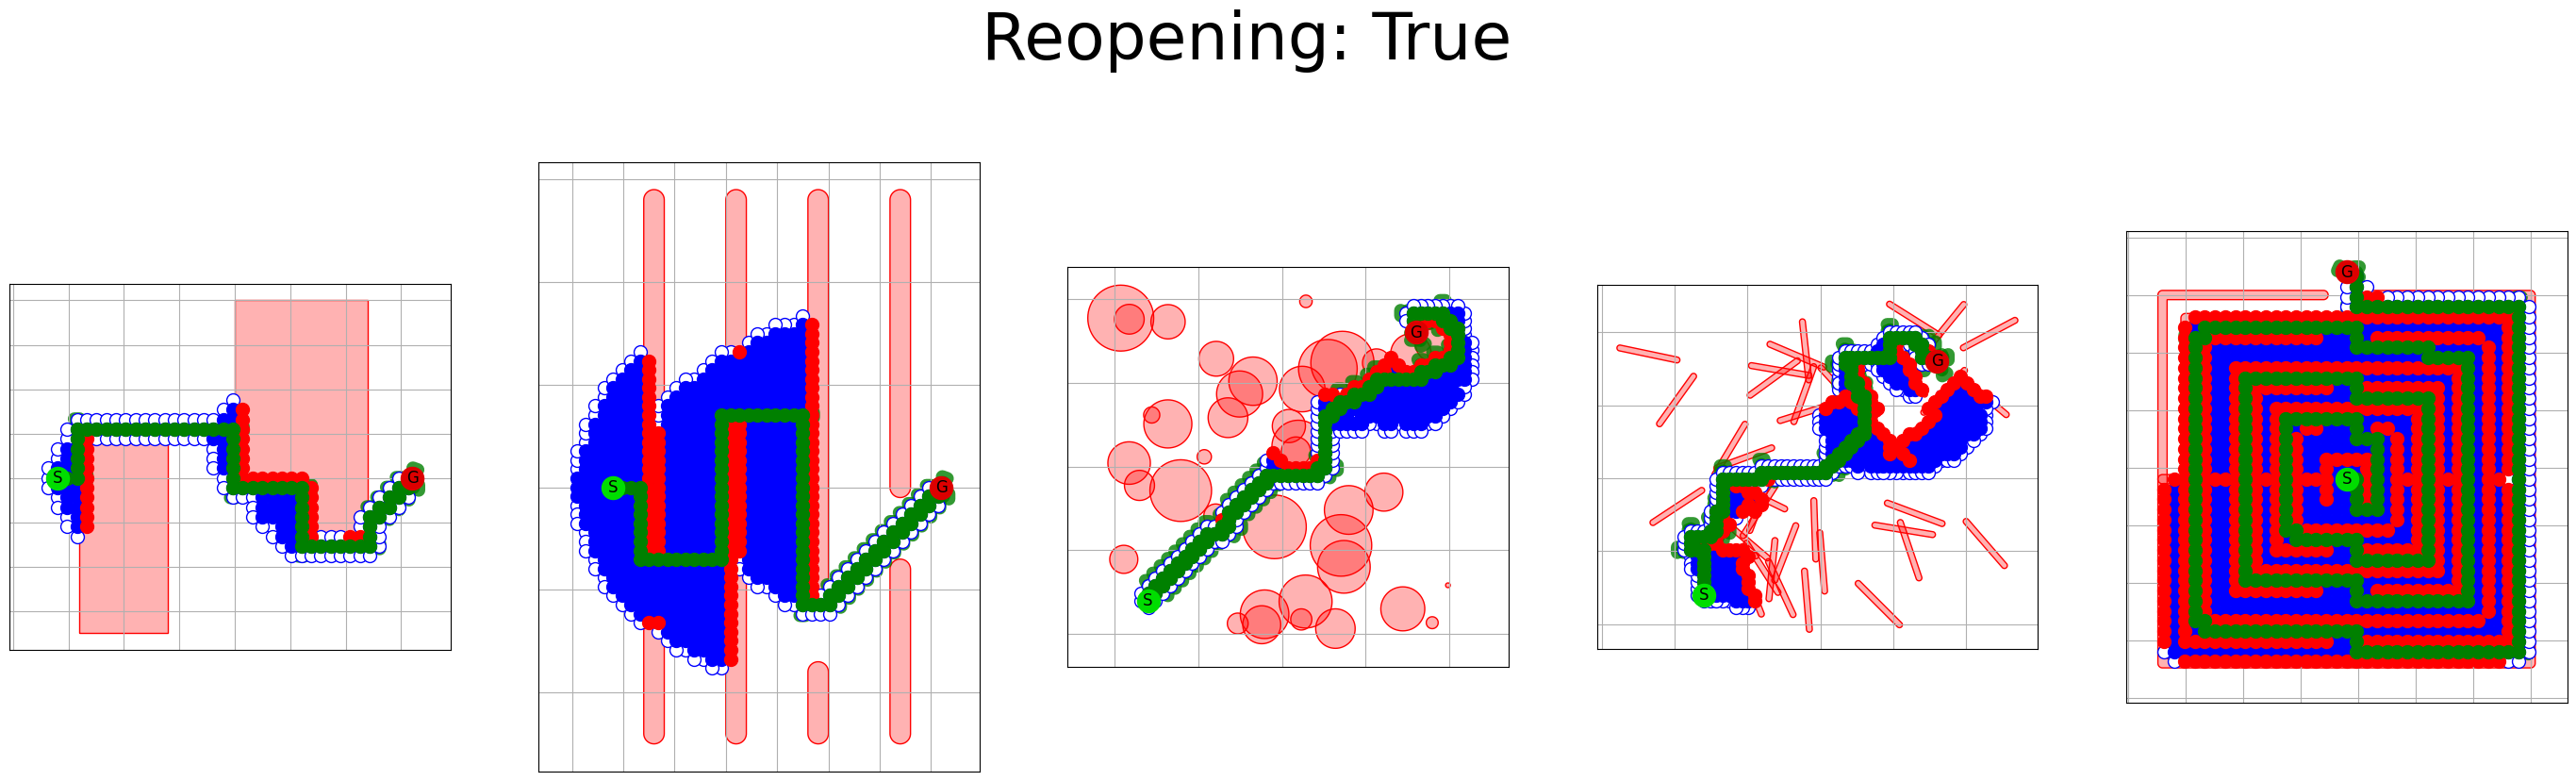

Drawing graph took 0.1891 seconds
Drawing obstacles took 0.0024 seconds
Drawing graph took 0.7282 seconds
Drawing obstacles took 0.0185 seconds
Drawing graph took 0.2233 seconds
Drawing obstacles took 0.0734 seconds
Drawing graph took 0.3539 seconds
Drawing obstacles took 0.0796 seconds
Drawing graph took 1.1709 seconds
Drawing obstacles took 0.0590 seconds


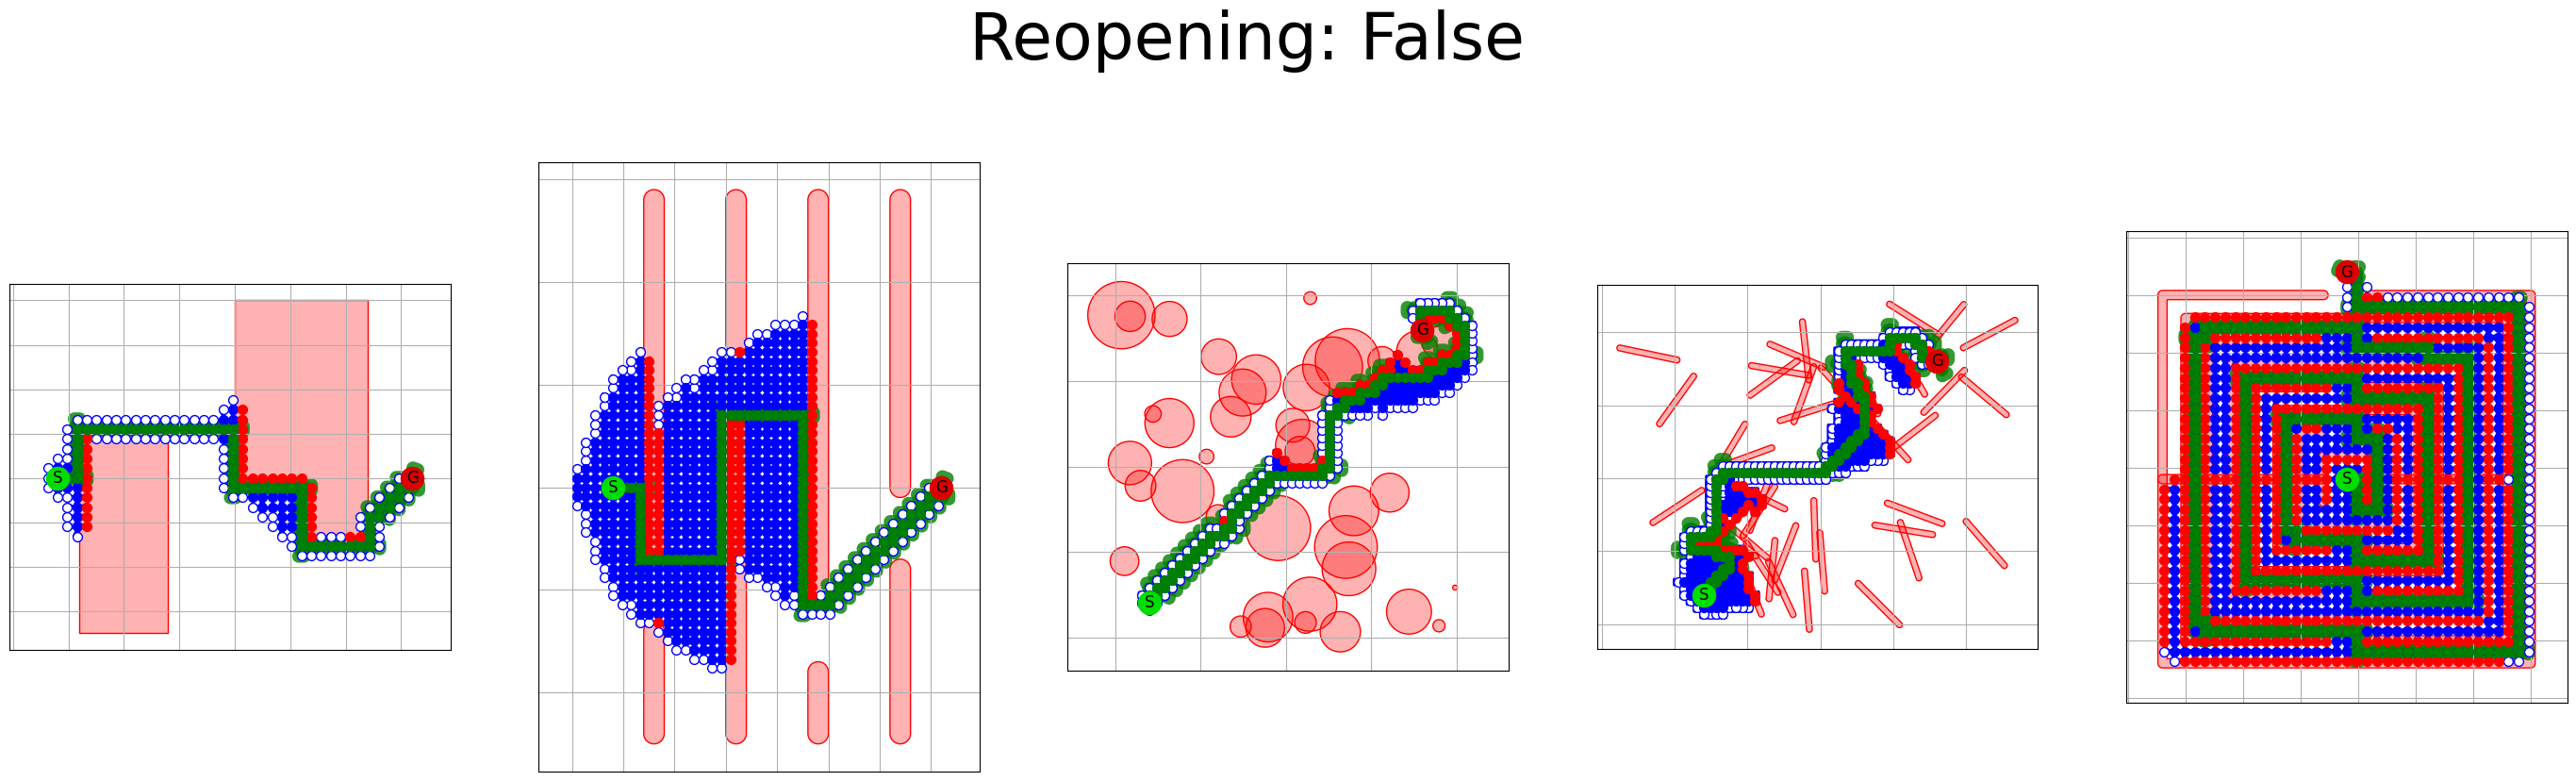

In [33]:
# show results

from IPVISAStar import aStarVisualize

activation_values = [True, False]

for i, (_, config_results) in enumerate(results):
    fig = plt.figure(figsize=(35,10))
    for j, (bench_name, benchmark_results) in enumerate(config_results.items()):
        astar = benchmark_results["astar"]
        solution = benchmark_results["solution"]
        ax = fig.add_subplot(1,len(config_results.items()),j + 1)
        aStarVisualize(planner=astar, solution=solution, ax=ax, nodeSize=(1000 / disc_values[i]), viz_solution=(len(solution) > 0))
    fig.suptitle(f"Reopening: {activation_values[i]}", fontsize=50)
    plt.show()

### Discussion

Enabling reopening does not significantly improve the path length in any of our benchmarks (although some changes can be seen when we look at the solutions of the mikado benchmark). However, it does lead to significant deterioration of the execution time.